

## **Experiment 4**

In [1]:
# ## 1. Setup and Imports
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Make sure 'experiment_utils.py' is in the same directory
try:
    import experiment_utils as utils
    import plotting_methods as plots
except ImportError:
    print("Error: 'experiment_utils.py' or 'plotting_methods.py' not found.")
    print("Please make sure the utility script from the previous answer is in the same directory.")
    exit()

# Matplotlib and Path Configuration
plt.rcParams.update({'font.size': 16})
from pathlib import Path
try:
    # Works when running from a .py file
    REPO_ROOT = Path(__file__).resolve()
except NameError:
    # Fallback for notebooks — use current working directory
    REPO_ROOT = Path.cwd().resolve()
while REPO_ROOT.name != "Learned-Optimizers-Benchmarking-Suite" and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent

BASE_DIR = REPO_ROOT / "experiments/experiment4"

In [2]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

### Experiment 4.1: Access Path Selection

- **Optimal Scan Accuracy Comparison**: Compare the LQO’s selected scan types (table/index) against those in the most optimal plan.
- **Selectivity Sensitivity**: Measure how well the LQO adapts to changes in predicate selectivity (e.g., does it switch to an index scan when selectivity decreases?).

**Goal**:  Identify areas where the LQO's decisions diverge from optimal choices and assess its sensitivity to changes in query characteristics.

In [3]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def create_scan_decision_legend(save_path="plots/4.1/scan_decisions_legend.pdf"):
    """
    Creates and saves a standalone legend for the scan decision plots.
    """
    print("\nGenerating standalone scan decision legend...")
    plt.rcParams.update({'font.size': 30})
    
    # Define the exact same colors and styles used in the main plot
    SCAN_COLORS = {"index_scan": "#4daf4a", "seq_scan": "#e41a1c"}
    PG_BG_COLORS = {"index_scan": "#4daf4a20", "seq_scan": "#e41a1c20"}

    # Create a new, temporary figure
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('off') # The axis is invisible; we only want the legend

    # Define all the elements that will appear in the legend (handles)
    legend_elements = [
        # Ground Truth Trajectories
        Line2D([0], [0], color='#377eb8', lw=2, marker='o', markersize=6, alpha=0.7, label='Index Scan Trajectory'),
        Line2D([0], [0], color='#ff7f00', lw=2, marker='s', markersize=6, alpha=0.7, label='Seq Scan Trajectory'),
        # LQO Decisions
        Line2D([0], [0], color=SCAN_COLORS['index_scan'], lw=3, marker='D', markersize=7, label='LQO chose index scan'),
        Line2D([0], [0], color=SCAN_COLORS['seq_scan'], lw=3, marker='D', markersize=7, label='LQO chose seq scan'),
        # PostgreSQL Background Decisions
        Patch(facecolor=PG_BG_COLORS['index_scan'], edgecolor='gray', label='PG chose index scan'),
        Patch(facecolor=PG_BG_COLORS['seq_scan'], edgecolor='gray', label='PG chose seq scan')
    ]
    
    # Create the legend and attach it to the figure
    legend = fig.legend(
        handles=legend_elements,
        loc='center',
        ncol=3, # Arrange in 3 columns for a compact look
        frameon=False # No box around the legend
    )

    # Save the figure, cropping to only the legend's bounding box
    output_dir = os.path.dirname(save_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    fig.savefig(
        save_path,
        bbox_inches='tight',
        bbox_extra_artists=[legend] # Important for cropping correctly
    )
    plt.close(fig) # Close the figure to free up memory
    print(f"Saved standalone legend to: {save_path}")
    
create_scan_decision_legend()


Generating standalone scan decision legend...
Saved standalone legend to: plots/4.1/scan_decisions_legend.pdf


In [4]:
def plot_scan_decisions(ground_truth_latencies, optimizer_data, save_dir="plots/4.1/", skip_neo=False, show_title=False, use_2x2_layout=False, log_scale=False):
    """
    Plots ground-truth latencies, overlays LQO decisions, and adds a background
    indicator for the classic PostgreSQL optimizer's decision.
    """
    plt.rcParams.update({'font.size': 30})
    # Define colors for different scan types
    SCAN_COLORS = {
        "index_scan": "#4daf4a",  # Green
        "seq_scan": "#e41a1c",    # Red
        "unknown": "#999999"       # Gray
    }
    
    # Define semi-transparent background colors for PostgreSQL's decisions
    PG_BG_COLORS = {
        "index_scan": "#4daf4a20",  # Light Green with alpha
        "seq_scan": "#e41a1c20"     # Light Red with alpha
    }

    queries_to_plot = {
        "1_joins_movie_company_0",
        "3_joins_movie_company_2",
        "5_joins_6b",
        "13_joins_19c",
        "16_joins_23a"
    }
    
    os.makedirs(save_dir, exist_ok=True)
    
    sorted_queries = sorted(optimizer_data.items(), 
                            key=lambda x: int(x[0].split('_')[0]))
    
    for query_template, optimizers_data in sorted_queries:
        if query_template not in queries_to_plot:
            continue
        
        if query_template not in ground_truth_latencies:
            print(f"Warning: No ground-truth latency data found for {query_template}, skipping plot.")
            continue
        
        # --- NEW: Extract PostgreSQL decisions first ---
        pg_decisions = {}
        if "PostgreSQL" in optimizers_data:
            for sel, data in optimizers_data["PostgreSQL"].items():
                pg_decisions[int(sel[:-1])] = data.get('scan_decision')

        # --- MODIFIED: Exclude PostgreSQL from the main list of subplots ---
        lqo_optimizers_base = ["NEO", "BAO", "LOGER", "FASTgres", "LERO"]
        if skip_neo:
            lqo_optimizers_base.remove("NEO")

        optimizers_present = [opt for opt in lqo_optimizers_base if opt in optimizers_data]

        if not optimizers_present:
            continue

        # --- LAYOUT LOGIC ---
        if use_2x2_layout:
            fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
            axes = axes.flatten()
            plot_order = ["LOGER", "LERO", "BAO", "FASTgres"]
        else:
            num_plots = len(optimizers_present)
            fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6), sharey=True)
            if num_plots == 1:
                axes = [axes]
            plot_order = optimizers_present
            
        num_optimizers = len(optimizers_present)

        # fig, axes = plt.subplots(1, num_optimizers, figsize=(6 * num_optimizers, 5), sharey=True)
        # if num_optimizers == 1:
        #     axes = [axes]
        
        selectivities = sorted(ground_truth_latencies[query_template].keys(), 
                               key=lambda x: int(x[:-1]))
        x_values = [int(s[:-1]) for s in selectivities]

        for i, optimizer in enumerate(plot_order):
            ax_idx = plot_order.index(optimizer)
            ax = axes[ax_idx]

            if use_2x2_layout and optimizer not in optimizers_present:
                ax.axis('off')
                continue

            # --- NEW: Plot PostgreSQL decision background ---
            if pg_decisions:
                # Add dummy patches for the legend
                if i == 0: # Only add legend entries once
                    ax.fill_between([],[], color=PG_BG_COLORS['index_scan'], label='PG chose index scan')
                    ax.fill_between([],[], color=PG_BG_COLORS['seq_scan'], label='PG chose seq scan')

                    # Dummy lines for LQO scan choices (ensure they always appear in legend)
                    ax.plot([], [], 'D-', color=SCAN_COLORS['index_scan'], linewidth=3, markersize=7,
                            label='LQO chose index scan')
                    ax.plot([], [], 'D-', color=SCAN_COLORS['seq_scan'], linewidth=3, markersize=7,
                            label='LQO chose seq scan')

                    # Ground-truth always exists, but we can still force them
                    ax.plot([], [], 'o-', color='#377eb8', linewidth=2, markersize=6, alpha=0.7,
                            label='Index Scan Trajectory')
                    ax.plot([], [], 's-', color='#ff7f00', linewidth=2, markersize=6, alpha=0.7,
                            label='Seq Scan Trajectory')
                
                # Iterate through selectivity ranges to draw shaded regions
                for j in range(len(x_values) - 1):
                    start_x = x_values[j]
                    end_x = x_values[j+1]
                    decision = pg_decisions.get(start_x)
                    if decision:
                        ax.axvspan(start_x, end_x, color=PG_BG_COLORS.get(decision), zorder=0)
                # Handle the last segment
                last_decision = pg_decisions.get(x_values[-1])
                if last_decision:
                    # Heuristically extend the last region
                    ax.axvspan(x_values[-1], x_values[-1] + (x_values[1]-x_values[0]), 
                               color=PG_BG_COLORS.get(last_decision), zorder=0)


            # 1. Plot ground-truth latency curves
            index_scan_times = [ground_truth_latencies[query_template][s].get("index_scan") for s in selectivities]
            seq_scan_times = [ground_truth_latencies[query_template][s].get("seq_scan") for s in selectivities]

            ax.plot(x_values, index_scan_times, 'o-', color='#377eb8', 
                    label='Index Scan Trajectory', linewidth=2, markersize=6, alpha=0.7)
            ax.plot(x_values, seq_scan_times, 's-', color='#ff7f00', 
                    label='Seq Scan Trajectory', linewidth=2, markersize=6, alpha=0.7)

            # 2. Plot LQO's actual execution time
            opt_perf_data = optimizers_data.get(optimizer, {})
            
            points = []
            for sel in selectivities:
                if sel in opt_perf_data:
                    point_data = opt_perf_data[sel]
                    if 'exec_time' in point_data and point_data['exec_time'] is not None:
                        points.append({
                            'x': int(sel[:-1]), 
                            'y': point_data['exec_time'], 
                            'decision': point_data.get('scan_decision', 'unknown')
                        })
            
            if points:
                segments = []
                current_segment = [points[0]]
                for k in range(1, len(points)):
                    if points[k]['decision'] == current_segment[-1]['decision']:
                        current_segment.append(points[k])
                    else:
                        segments.append(current_segment)
                        current_segment = [points[k-1], points[k]]
                
                segments.append(current_segment)
                
                for seg_points in segments:
                    decision = seg_points[-1]['decision']
                    color = SCAN_COLORS.get(decision, SCAN_COLORS['unknown'])
                    label = f'LQO chose {decision.replace("_", " ")}'
                    
                    seg_x = [p['x'] for p in seg_points]
                    seg_y = [p['y'] for p in seg_points]
                    
                    ax.plot(seg_x, seg_y, 'D-', 
                           color=color,
                           linewidth=3, markersize=7,
                           label=label)

            # Customize subplot
            ax.set_title(f"{optimizer}", fontsize=36)
            # ax.set_xlabel("Selectivity (%)", fontsize=16)
            if i == 0:
                handles, labels = ax.get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                legend_handles = list(by_label.values())
                legend_labels = list(by_label.keys())
                # ax.set_ylabel("Execution Time (ms)", fontsize=16)

            xticklabels = [
                s if s != "10%" else ""  # hide 10% label
                for s in selectivities
            ]            
            ax.set_xticks(x_values)
            ax.set_xticklabels(xticklabels, rotation=60, ha="center", fontsize=36)
            ax.tick_params(axis='y', labelsize=36)
            ax.grid(True, linestyle='--', alpha=0.6)
            if log_scale:
                ax.set_yscale('log')

            if use_2x2_layout:
                if ax_idx in [0, 2]: ax.set_ylabel("", fontsize=18)
                # if ax_idx in [2, 3]: ax.set_xlabel("Selectivity", fontsize=16)
            else:
                # ax.set_xlabel("Selectivity", fontsize=16)
                if i == 0: ax.set_ylabel("", fontsize=18)

            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            # ax.legend(by_label.values(), by_label.keys(), fontsize=12)

        plt.tight_layout()
        ax.margins(x=0)
        if show_title:
            fig.suptitle(f"Scan Decisions for: {query_template}", fontsize=20, y=1.04)
        output_path = os.path.join(save_dir, f"{query_template}_scan_decisions.pdf")
        plt.savefig(output_path, bbox_inches='tight')
        plt.show()
        # plt.close(fig)

#### i. Synthetic Benchmark

In [5]:
# Example usage
SYNTHETIC_ROOT = os.path.join(BASE_DIR, "4.1/synthetic")
print("Extracting data for synthetic benchmark...")

synthetic_latencies = utils.extract_scan_latencies(SYNTHETIC_ROOT)
print("Synthetic latencies extracted.")

Extracting data for synthetic benchmark...
Synthetic latencies extracted.


Synthetic optimizer data extracted.
Found 5 optimizer decisions for synthetic benchmark.
Optimizer decisions: {'3_joins_movie_company_2': {'PostgreSQL': {'40%': {'exec_time': 3101.619, 'scan_decision': 'seq_scan'}, '100%': {'exec_time': 2935.452, 'scan_decision': 'seq_scan'}, '60%': {'exec_time': 2270.333, 'scan_decision': 'seq_scan'}, '80%': {'exec_time': 2602.261, 'scan_decision': 'seq_scan'}, '20%': {'exec_time': 614.482, 'scan_decision': 'seq_scan'}, '10%': {'exec_time': 489.672, 'scan_decision': 'index_scan'}, '0%': {'exec_time': 159.507, 'scan_decision': 'index_scan'}}, 'NEO': {'40%': {'exec_time': 2285.54, 'scan_decision': 'seq_scan'}, '100%': {'exec_time': 3399.892, 'scan_decision': 'seq_scan'}, '60%': {'exec_time': 2780.515, 'scan_decision': 'seq_scan'}, '80%': {'exec_time': 3097.658, 'scan_decision': 'seq_scan'}, '20%': {'exec_time': 1595.203, 'scan_decision': 'seq_scan'}, '10%': {'exec_time': 2005.463, 'scan_decision': 'index_scan'}, '0%': {'exec_time': 142.579, 'scan_decisi

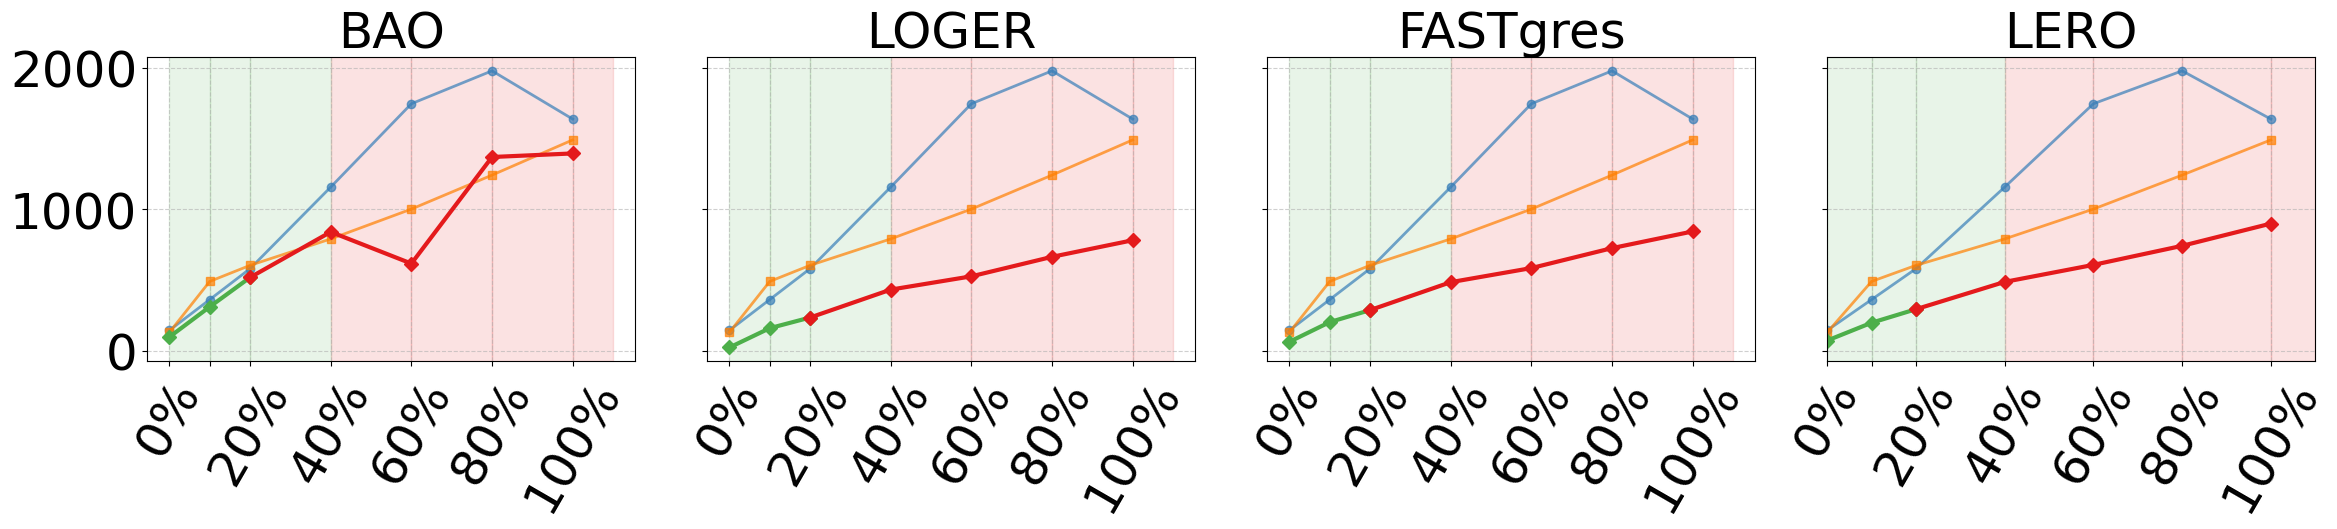

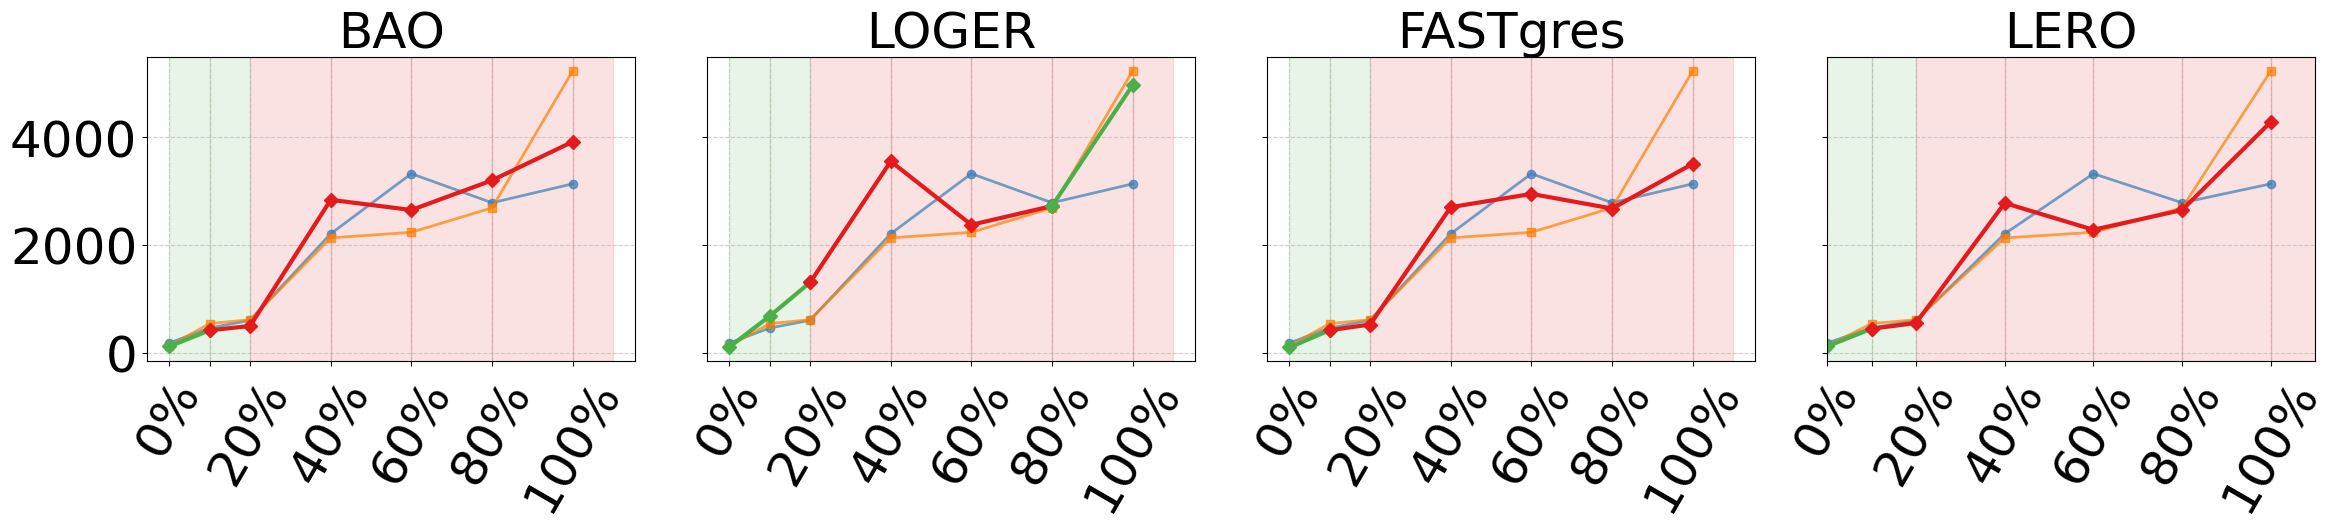

In [6]:
# 2. Get what each optimizer actually did (exec time and scan decision)
synthetic_scan_target = {'relation_name': 'movie_companies', 'alias': 'mc', 'column_name': 'company_id'}
synthetic_optimizer_data = utils.extract_optimizer_data(SYNTHETIC_ROOT, scan_target=synthetic_scan_target)
print("Synthetic optimizer data extracted.")
print(f"Found {len(synthetic_optimizer_data)} optimizer decisions for synthetic benchmark.")
print("Optimizer decisions:", synthetic_optimizer_data)
print("Extraction complete.")

# Plot the results for the synthetic benchmark
if synthetic_latencies and synthetic_optimizer_data:
    print("\nPlotting results for synthetic benchmark...")
    plot_scan_decisions(
        synthetic_latencies, 
        synthetic_optimizer_data,
        save_dir="plots/4.1/synthetic/",
        show_title=False,
        log_scale=False,
        skip_neo=True,
    )
else:
    print("\nNo data found for synthetic benchmark, skipping plots.")

##### **Key takeaways**
- **NEO** tends to make and stick to wrong decisions in regards to the correct scan operator, regardless of the selectivity 
- **BAO and LERO** perform nearly flawlessly up to a certain threshold. However, beyond this point, they tend to favor sequential scans even when index scans would be faster.  
- **LOGER** is the only optimizer that deviates from this pattern by dynamically estimating the faster scan method rather than relying on a fixed threshold. (e.g. the synthetic query with 3 joins)
- **FASTgres** failed to find a context for any of the test queries, defaulting to PostgreSQL's optimizer plan without any modifications.  

#### ii. Complete Join Order Benchmark with an index on the title.production_year column

In [7]:
JOB_INDEX_ROOT = os.path.join(BASE_DIR, "4.1/added_index")
print("\nExtracting data for JOB benchmark with added index...")
# 1. Get ground-truth latencies
job_latencies = utils.extract_scan_latencies(JOB_INDEX_ROOT)


Extracting data for JOB benchmark with added index...


In [8]:
# 2. Get optimizer decisions and performance
job_scan_target = {'relation_name': 'title', 'alias': 't', 'column_name': 'production_year'}
job_optimizer_data = utils.extract_optimizer_data(JOB_INDEX_ROOT, scan_target=job_scan_target)
print("Extraction complete.")

Extraction complete.



Plotting results for added_index benchmark...


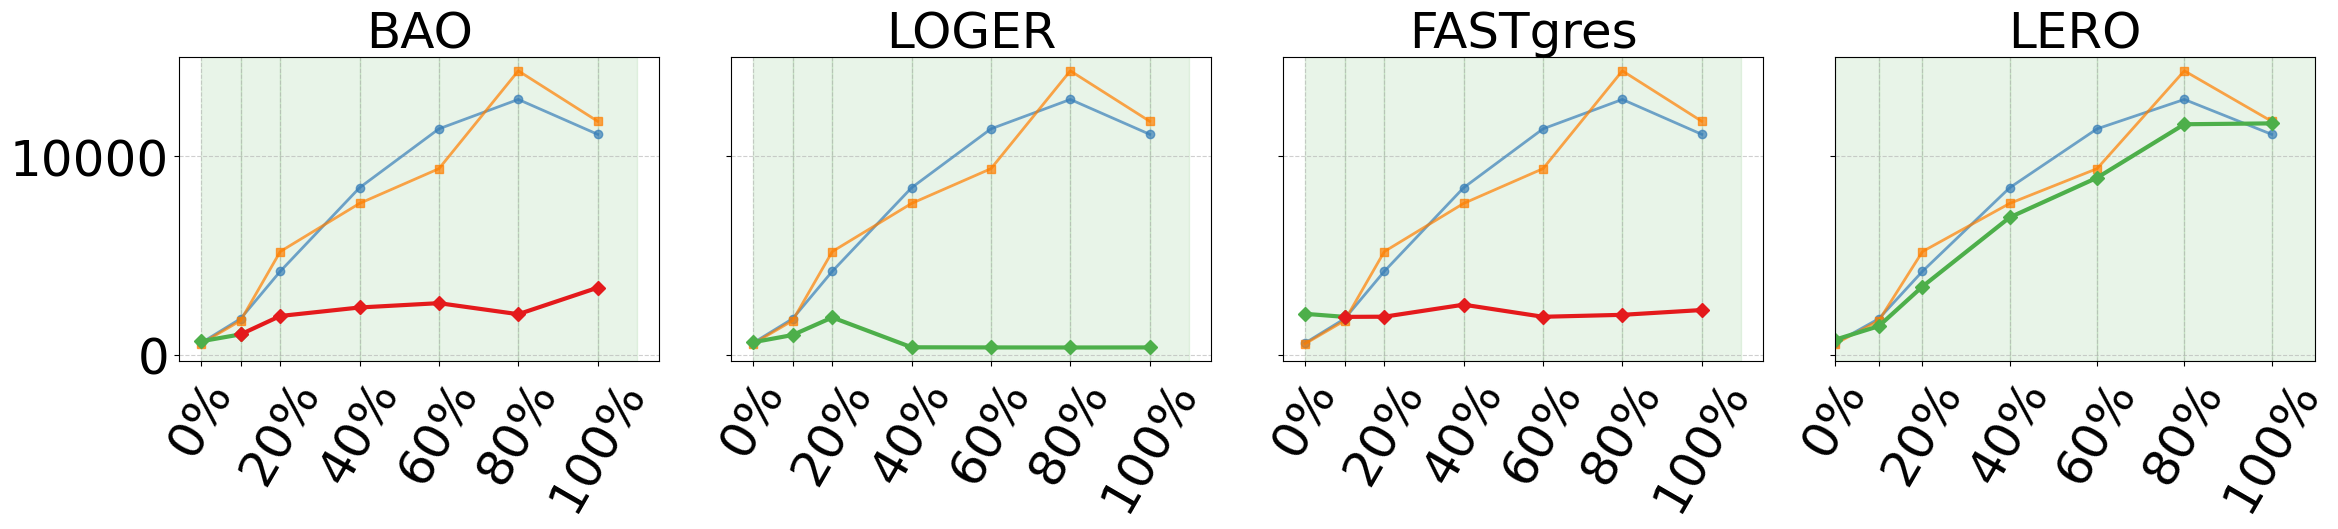

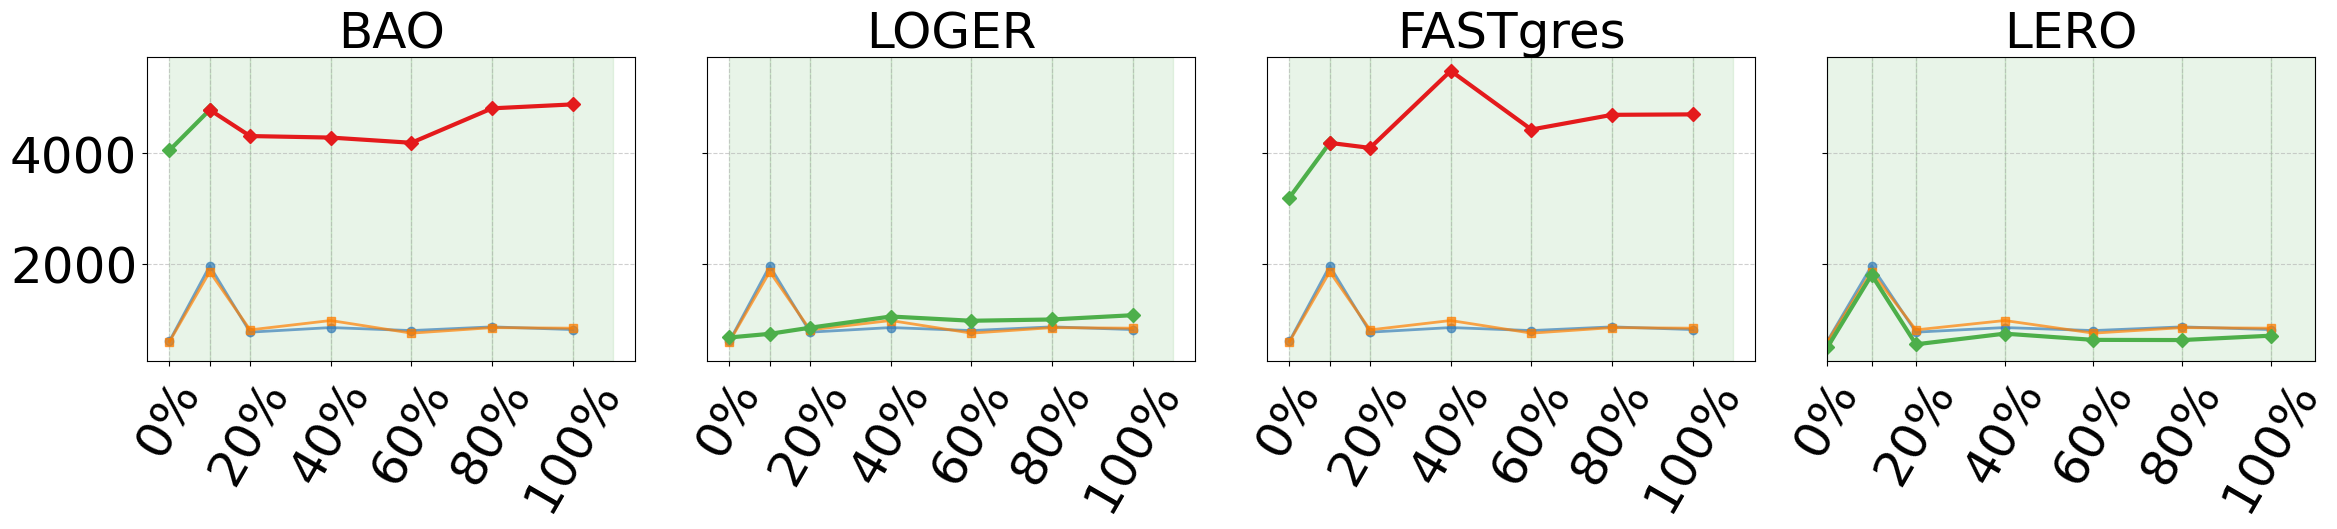

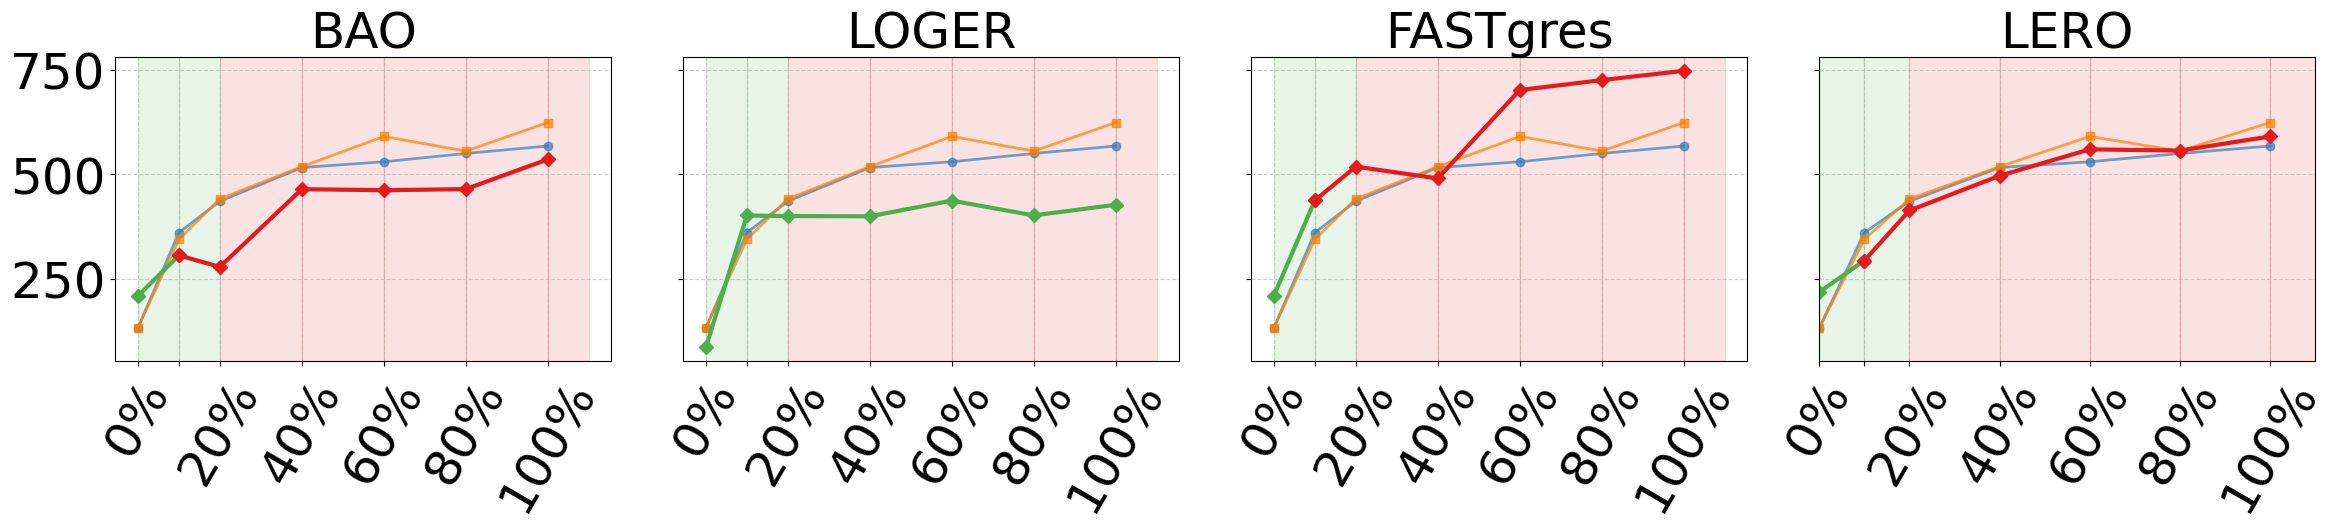

In [9]:
# Plot the results for the added_index benchmark
if job_latencies and job_optimizer_data:
    print("\nPlotting results for added_index benchmark...")
    plot_scan_decisions(
        job_latencies, 
        job_optimizer_data,
        save_dir="plots/4.1/added_index/",
        skip_neo=True,  # Skip NEO for this benchmark
        show_title=False,
        use_2x2_layout=False,
        log_scale=False
    )
else:
    print("\nNo data found for added_index benchmark, skipping plots.")

In [10]:
import os
import matplotlib.pyplot as plt

def plot_scan_decisions_2x2(ground_truth_latencies, optimizer_data, save_dir="plots/4.1/", skip_neo=False, log_scale=False):
    """
    Plots scan decisions using a fixed 2x2 layout with smaller fonts.
    Only uses the 2x2 layout, excluding PostgreSQL from main subplots.
    """
    plt.rcParams.update({'font.size': 12})  # decreased font sizes by 10
    
    SCAN_COLORS = {
        "index_scan": "#4daf4a",
        "seq_scan": "#e41a1c",
        "unknown": "#999999"
    }
    
    PG_BG_COLORS = {
        "index_scan": "#4daf4a20",
        "seq_scan": "#e41a1c20"
    }

    queries_to_plot = {
        "1_joins_movie_company_0",
        "3_joins_movie_company_2",
        "5_joins_6b",
        "13_joins_19c",
        "16_joins_23a"
    }
    
    os.makedirs(save_dir, exist_ok=True)
    
    sorted_queries = sorted(optimizer_data.items(), key=lambda x: int(x[0].split('_')[0]))
    
    for query_template, optimizers_data in sorted_queries:
        if query_template not in queries_to_plot or query_template not in ground_truth_latencies:
            continue

        # Extract PostgreSQL decisions
        pg_decisions = {}
        if "PostgreSQL" in optimizers_data:
            for sel, data in optimizers_data["PostgreSQL"].items():
                pg_decisions[int(sel[:-1])] = data.get('scan_decision')

        # Optimizers excluding PostgreSQL
        lqo_optimizers_base = ["LOGER", "LERO", "BAO", "FASTgres"]
        if not skip_neo and "NEO" in optimizers_data:
            lqo_optimizers_base.insert(0, "NEO")

        optimizers_present = [opt for opt in lqo_optimizers_base if opt in optimizers_data]
        if not optimizers_present:
            continue

        # --- 2x2 layout ---
        fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True, sharex=True)
        axes = axes.flatten()
        plot_order = ["LOGER", "LERO", "BAO", "FASTgres"]

        selectivities = sorted(ground_truth_latencies[query_template].keys(), key=lambda x: int(x[:-1]))
        x_values = [int(s[:-1]) for s in selectivities]

        for i, optimizer in enumerate(plot_order):
            ax = axes[i]
            if optimizer not in optimizers_present:
                ax.axis('off')
                continue

            # Plot PostgreSQL decision background
            if pg_decisions:
                if i == 0:  # legend only once
                    ax.fill_between([], [], color=PG_BG_COLORS['index_scan'], label='PG chose index scan')
                    ax.fill_between([], [], color=PG_BG_COLORS['seq_scan'], label='PG chose seq scan')
                    ax.plot([], [], 'D-', color=SCAN_COLORS['index_scan'], linewidth=3, markersize=7,
                            label='LQO chose index scan')
                    ax.plot([], [], 'D-', color=SCAN_COLORS['seq_scan'], linewidth=3, markersize=7,
                            label='LQO chose seq scan')
                    ax.plot([], [], 'o-', color='#377eb8', linewidth=2, markersize=6, alpha=0.7,
                            label='Index Scan Trajectory')
                    ax.plot([], [], 's-', color='#ff7f00', linewidth=2, markersize=6, alpha=0.7,
                            label='Seq Scan Trajectory')
                for j in range(len(x_values)-1):
                    start_x, end_x = x_values[j], x_values[j+1]
                    decision = pg_decisions.get(start_x)
                    if decision:
                        ax.axvspan(start_x, end_x, color=PG_BG_COLORS.get(decision), zorder=0)
                last_decision = pg_decisions.get(x_values[-1])
                if last_decision:
                    ax.axvspan(x_values[-1], x_values[-1] + (x_values[1]-x_values[0]), color=PG_BG_COLORS.get(last_decision), zorder=0)

            # Ground-truth latency curves
            index_scan_times = [ground_truth_latencies[query_template][s].get("index_scan") for s in selectivities]
            seq_scan_times = [ground_truth_latencies[query_template][s].get("seq_scan") for s in selectivities]
            ax.plot(x_values, index_scan_times, 'o-', color='#377eb8', linewidth=2, markersize=6, alpha=0.7)
            ax.plot(x_values, seq_scan_times, 's-', color='#ff7f00', linewidth=2, markersize=6, alpha=0.7)

            # LQO execution time
            opt_perf_data = optimizers_data.get(optimizer, {})
            points = []
            for sel in selectivities:
                if sel in opt_perf_data and opt_perf_data[sel].get('exec_time') is not None:
                    points.append({'x': int(sel[:-1]), 'y': opt_perf_data[sel]['exec_time'], 
                                   'decision': opt_perf_data[sel].get('scan_decision', 'unknown')})
            if points:
                segments = []
                current_segment = [points[0]]
                for k in range(1, len(points)):
                    if points[k]['decision'] == current_segment[-1]['decision']:
                        current_segment.append(points[k])
                    else:
                        segments.append(current_segment)
                        current_segment = [points[k-1], points[k]]
                segments.append(current_segment)
                for seg_points in segments:
                    decision = seg_points[-1]['decision']
                    color = SCAN_COLORS.get(decision, SCAN_COLORS['unknown'])
                    seg_x = [p['x'] for p in seg_points]
                    seg_y = [p['y'] for p in seg_points]
                    ax.plot(seg_x, seg_y, 'D-', color=color, linewidth=3, markersize=7)

            ax.set_title(f"{optimizer}", fontsize=20)  # decreased font size
            ax.set_xticks(x_values)
            ax.set_xticklabels(selectivities, rotation=60, ha="center", fontsize=18)
            ax.tick_params(axis='y', labelsize=18)
            ax.grid(True, linestyle='--', alpha=0.6)
            if log_scale:
                ax.set_yscale('log')

        # Add legend once for 2x2
        # handles, labels = axes[0].get_legend_handles_labels()
        # by_label = dict(zip(labels, handles))
        # fig.legend(by_label.values(), by_label.keys(),
        #            loc='upper center', bbox_to_anchor=(0.5, 1.05),
        #            ncol=4, fontsize=18, handlelength=3.0, handleheight=1.5,
        #            frameon=True, facecolor='white', edgecolor='black', fancybox=True)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        output_path = os.path.join(save_dir, f"{query_template}_scan_decisions.pdf")
        plt.savefig(output_path, bbox_inches='tight')
        plt.show()

In [11]:
# # Plot the results for the added_index benchmark
# if job_latencies and job_optimizer_data:
#     print("\nPlotting results for added_index benchmark...")
#     plot_scan_decisions_2x2(
#         job_latencies, 
#         job_optimizer_data,
#         save_dir="plots/4.1/added_index/2_by_2/",
#         skip_neo=True,  # Skip NEO for this benchmark
#         log_scale=True
#     )
# else:
#     print("\nNo data found for added_index benchmark, skipping plots.")

In [12]:
# ## 3. Binned Aggregate Scan Operator Accuracy

def calculate_binned_scan_accuracy(ground_truth_latencies, optimizer_data, bins=None):
    """
    Calculates the accuracy of each optimizer in selecting the correct scan operator,
    binned by the number of joins in the query.

    Args:
        ground_truth_latencies (dict): Ground truth data.
        optimizer_data (dict): Optimizer decision data.
        bins (list of tuples): A list defining the join complexity bins.
                               Example: [(1, 4), (5, 9), (10, float('inf'))]

    Returns:
        dict: A dictionary with binned accuracy statistics for each optimizer.
    """
    if bins is None:
        bins = [(1, 5), (6, 11), (12, float('inf'))] # Default bins

    # Create a nested dictionary structure for the results
    # a dict of dicts of dicts
    # accuracy_stats['optimizer']['bin_label']['correct' or 'total']
    accuracy_stats = {
        opt: {
            f"{low}-{high if high != float('inf') else 'inf'} joins": {'correct': 0, 'total': 0}
            for low, high in bins
        }
        for opt in utils.OPTIMIZERS + ["PostgreSQL"]
    }

    # Iterate through every query template
    for query, optimizers in optimizer_data.items():
        if query not in ground_truth_latencies:
            continue
            
        # --- Determine the join level and the correct bin for this query ---
        try:
            join_level = int(query.split('_')[0])
        except (ValueError, IndexError):
            continue
            
        target_bin_label = None
        for low, high in bins:
            if low <= join_level <= high:
                target_bin_label = f"{low}-{high if high != float('inf') else 'inf'} joins"
                break
        if not target_bin_label:
            continue

        # Iterate through each optimizer's results for that query
        for optimizer_name, selectivities_data in optimizers.items():
            if optimizer_name not in accuracy_stats:
                continue
            
            if optimizer_name == "NEO":
                continue

            # Iterate through each selectivity level
            for selectivity, data in selectivities_data.items():
                # Get ground truth
                ground_truth = ground_truth_latencies.get(query, {}).get(selectivity, {})
                index_time = ground_truth.get('index_scan')
                seq_time = ground_truth.get('seq_scan')
                
                if index_time is None or seq_time is None:
                    continue
                
                optimal_choice = "index_scan" if index_time <= seq_time else "seq_scan"

                # Get the optimizer's decision
                optimizer_choice = data.get('scan_decision')

                # Compare and update stats in the correct bin
                if optimizer_choice and optimizer_choice != "unknown":
                    accuracy_stats[optimizer_name][target_bin_label]['total'] += 1
                    if optimizer_choice == optimal_choice:
                        accuracy_stats[optimizer_name][target_bin_label]['correct'] += 1

    return accuracy_stats


# --- Run the Binned Accuracy Calculation ---
if job_optimizer_data and job_latencies:
    print("\n--- Binned Scan Operator Selection Accuracy for JOB Workload ---")

    # Define the join complexity bins
    # Bin 1: Simple queries (1-5 joins)
    # Bin 2: Medium queries (6-12 joins)
    # Bin 3: Complex queries (13+ joins)
    join_bins = [(1, 5), (6, 11), (12, float('inf'))]

    binned_accuracy = calculate_binned_scan_accuracy(job_latencies, job_optimizer_data, bins=join_bins)

    # --- Print the results in a structured format ---
    optimizers_to_print = sorted([opt for opt, data in binned_accuracy.items() if any(bin_data['total'] > 0 for bin_data in data.values())])

    for bin_label in [f"{l}-{h if h != float('inf') else 'inf'} joins" for l, h in join_bins]:
        print(f"\n--- Accuracy for Bin: {bin_label} ---")
        print(f"{'Optimizer':<12} | {'Accuracy':<12} | {'Correct/Total':<15}")
        print("-" * 45)
        
        has_data_in_bin = False
        for optimizer in optimizers_to_print:
            stats = binned_accuracy[optimizer][bin_label]
            if stats['total'] > 0:
                has_data_in_bin = True
                accuracy = (stats['correct'] / stats['total']) * 100
                report_str = f"({stats['correct']} / {stats['total']})"
                print(f"{optimizer:<12} | {accuracy:6.2f}%       | {report_str:<15}")
        
        if not has_data_in_bin:
            print("No data available for this bin in the current workload.")

else:
    print("Could not calculate binned accuracy because data for the JOB workload was not loaded.")


--- Binned Scan Operator Selection Accuracy for JOB Workload ---

--- Accuracy for Bin: 1-5 joins ---
Optimizer    | Accuracy     | Correct/Total  
---------------------------------------------
BAO          |  43.70%       | (52 / 119)     
FASTgres     |  52.94%       | (63 / 119)     
LERO         |  46.22%       | (55 / 119)     
LOGER        |  47.06%       | (56 / 119)     
PostgreSQL   |  46.22%       | (55 / 119)     

--- Accuracy for Bin: 6-11 joins ---
Optimizer    | Accuracy     | Correct/Total  
---------------------------------------------
BAO          |  47.62%       | (30 / 63)      
FASTgres     |  47.62%       | (30 / 63)      
LERO         |  44.44%       | (28 / 63)      
LOGER        |  44.44%       | (28 / 63)      
PostgreSQL   |  44.44%       | (28 / 63)      

--- Accuracy for Bin: 12-inf joins ---
Optimizer    | Accuracy     | Correct/Total  
---------------------------------------------
BAO          |  55.37%       | (98 / 177)     
FASTgres     |  55.03%    

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def create_aggregated_legend(optimizer_colors, patterns, save_path):
    """
    Creates a standalone legend for aggregated plots.

    Args:
        optimizer_colors (dict): Mapping of optimizer names to colors.
        patterns (dict): Mapping of optimizer names to hatch patterns.
        save_path (str): Path to save the legend PDF.
    """
    fig_legend = plt.figure(figsize=(8, 2))
    ax = fig_legend.add_subplot(111)

    handles = []
    labels = []
    for optimizer, color in optimizer_colors.items():
        patch = plt.Rectangle(
            (0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=patterns.get(optimizer, '')
        )
        handles.append(patch)
        labels.append(optimizer)

    ax.legend(handles, labels, loc='center', ncol=len(optimizer_colors),
              frameon=True, facecolor='white', edgecolor='black', fontsize=14)
    ax.axis('off')
    
    fig_legend.tight_layout()
    fig_legend.savefig(save_path, bbox_inches='tight', dpi=600)
    plt.close(fig_legend)
    print(f"Legend saved to: {save_path}")


# Example usage
optimizer_colors = {
    'PostgreSQL': '#1f77b4', 'NEO': '#ff7f0e', 'BAO': '#2ca02c',
    'LOGER': '#d62728', 'FASTgres': '#9467bd', 'LERO': '#8c564b'
}
patterns = {
    'PostgreSQL': '', 'NEO': '//', 'BAO': '\\\\', 'LOGER': '||',
    'FASTgres': '--', 'LERO': 'OO'
}

create_aggregated_legend(optimizer_colors, patterns, "plots/4.1/regret_legend.pdf")


Legend saved to: plots/4.1/regret_legend.pdf


Plot saved to: plots/4.1/binned_scan_accuracy.pdf


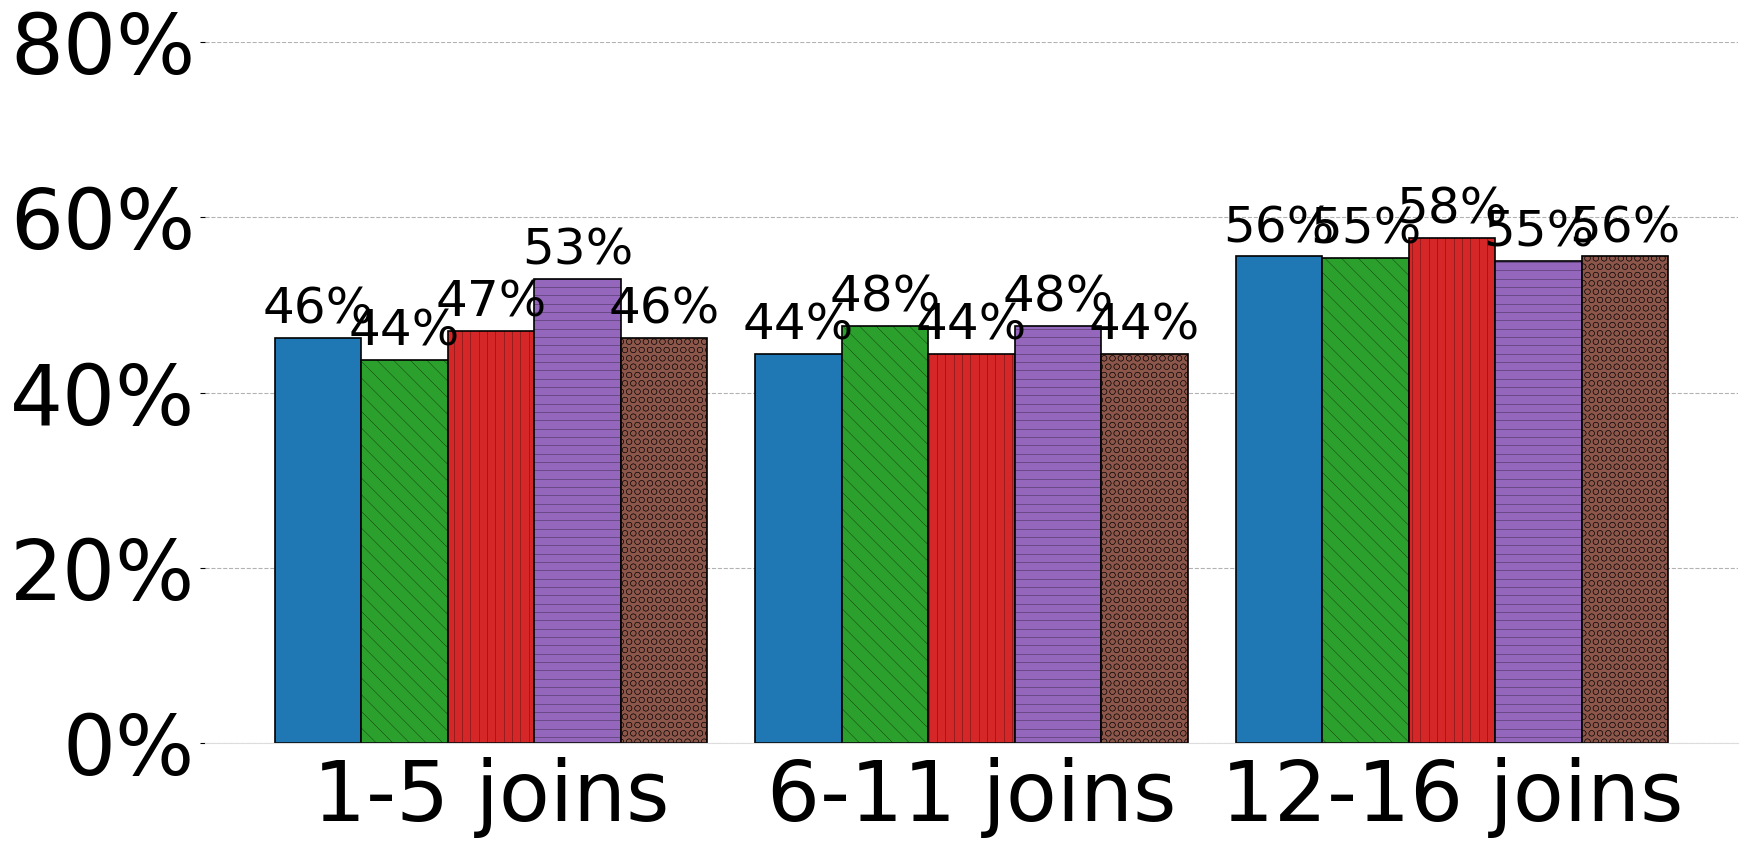

In [14]:
# ## 4. Visualize Binned Scan Accuracy (Final Polished Version)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

def plot_styled_binned_accuracy(binned_accuracy_data, save_path="plots/4.1/binned_scan_accuracy.pdf"):
    """
    Generates a final, polished grouped bar chart for binned accuracy,
    with a fixed y-axis and a specific optimizer order.

    Args:
        binned_accuracy_data (dict): The output from the calculate_binned_scan_accuracy function.
        save_path (str): The file path to save the generated plot.
    """
    # --- 1. Data Preparation ---

    # Define the styling and the plotting order for each optimizer
    optimizer_order = [
        'PostgreSQL', 'NEO', 'BAO', 'LOGER', 'FASTgres', 'LERO'
    ]
    
    optimizer_colors = {
        'PostgreSQL': '#1f77b4',  # Blue
        'NEO': '#ff7f0e',       # Orange
        'BAO': '#2ca02c',       # Green
        'LOGER': '#d62728',     # Red
        'FASTgres': '#9467bd',  # Purple
        'LERO': '#8c564b'       # Brown
    }
    
    patterns = {
        'PostgreSQL': '',       # Solid (no hatch)
        'NEO': '//',       # Forward slashes
        'BAO': '\\\\',      # Backward slashes (backslashes must be escaped)
        'LOGER': '||',       # Vertical lines
        'FASTgres': '--',      # Horizontal lines
        'LERO': 'OO'        # Large circles
    }
    plt.rcParams['hatch.linewidth'] = 0.2

    # Filter the final list of optimizers to plot based on what data is available
    # while maintaining the desired order.
    available_optimizers = [
        opt for opt in optimizer_order 
        if opt in binned_accuracy_data and any(bin_data['total'] > 0 for bin_data in binned_accuracy_data[opt].values())
    ]

    if not available_optimizers:
        print("No data available to plot.")
        return

    # Get bin labels in the correct order
    bin_labels = list(binned_accuracy_data[available_optimizers[0]].keys())
    
    # Extract accuracy percentages for each optimizer across the bins
    accuracy_values = {opt: [] for opt in available_optimizers}
    for bin_label in bin_labels:
        for optimizer in available_optimizers:
            stats = binned_accuracy_data[optimizer][bin_label]
            if stats['total'] > 0:
                accuracy = (stats['correct'] / stats['total']) * 100
                accuracy_values[optimizer].append(accuracy)
            else:
                accuracy_values[optimizer].append(0)

    # --- 2. Plotting Setup ---
    
    x = np.arange(len(bin_labels))
    width = 0.18 # Adjusted width slightly for better spacing
    num_optimizers = len(available_optimizers)
    
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.rcParams.update({'font.size': 24})
    
    # --- 3. Create Bars for Each Optimizer in the specified order ---
    
    for i, optimizer in enumerate(available_optimizers):
        offset = width * (i - (num_optimizers - 1) / 2)
        
        bars = ax.bar(x + offset, accuracy_values[optimizer], width,
                      label=optimizer,
                      color=optimizer_colors.get(optimizer, 'grey'),
                      hatch=patterns.get(optimizer, ''),
                      edgecolor='black',
                      linewidth=1.2)
        
        ax.bar_label(bars, padding=3, fmt='%.0f%%', fontsize=36)

    # --- 4. Final Chart Customization (with requested changes) ---
    
    ax.set_ylabel('', fontsize=16, labelpad=15)
    
    ax.set_xticks(x, [label.replace("_", " ").replace("inf", "16") for label in bin_labels], fontsize=60)
    ax.tick_params(axis='x', length=0, pad=10)
    ax.tick_params(axis='y', labelsize=60)
    
    # **CHANGE 1: Set strict Y-axis limits from 0 to 100**
    ax.set_ylim(0, 80)
    # Use a ticker to ensure the y-axis labels are clean (e.g., 0, 20, 40...)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    
    # ax.legend(
    #     loc='upper center',
    #     bbox_to_anchor=(0.5, 1.3),
    #     ncol=num_optimizers,
    #     fontsize=24,
    #     handlelength=3.0,
    #     handleheight=1.5,
    #     frameon=True,
    #     facecolor='white',
    #     edgecolor='black',
    #     fancybox=True
    # )
    
    fig.tight_layout(rect=[0, 0, 1, 0.9])
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=600)
        print(f"Plot saved to: {save_path}")
        
    plt.show()

# --- Generate the final plot ---
if 'binned_accuracy' in locals():
    # **CHANGE 2: Rename 'Postgres' to 'PostgreSQL' in the data to match the color key**
    if 'Postgres' in binned_accuracy and 'PostgreSQL' not in binned_accuracy:
        binned_accuracy['PostgreSQL'] = binned_accuracy.pop('Postgres')

    plot_styled_binned_accuracy(binned_accuracy)
else:
    print("Binned accuracy data not found. Please run the calculation cell first.")


--- Calculating Binned Regret for JOB Workload ---

--- Summary of Mean Absolute Regret (ms) ---

--- Bin: 1-5 joins ---
NEO          | Mean Abs. Regret: 22589.20 ms
BAO          | Mean Abs. Regret:  -529.58 ms
LERO         | Mean Abs. Regret:   -25.14 ms
LOGER        | Mean Abs. Regret:  -884.84 ms
FASTgres     | Mean Abs. Regret:  -468.37 ms
PostgreSQL   | Mean Abs. Regret:   129.00 ms

--- Bin: 6-11 joins ---
NEO          | Mean Abs. Regret:  6122.41 ms
BAO          | Mean Abs. Regret:   182.16 ms
LERO         | Mean Abs. Regret:   -17.70 ms
LOGER        | Mean Abs. Regret:  -220.55 ms
FASTgres     | Mean Abs. Regret:    23.25 ms
PostgreSQL   | Mean Abs. Regret:    85.93 ms

--- Bin: 12-inf joins ---
NEO          | Mean Abs. Regret: 17857.48 ms
BAO          | Mean Abs. Regret:  -508.76 ms
LERO         | Mean Abs. Regret:  -305.07 ms
LOGER        | Mean Abs. Regret: -1630.52 ms
FASTgres     | Mean Abs. Regret:  -836.08 ms
PostgreSQL   | Mean Abs. Regret:   161.77 ms


Plot saved to: plots/4.1/mean_absolute_regret.pdf


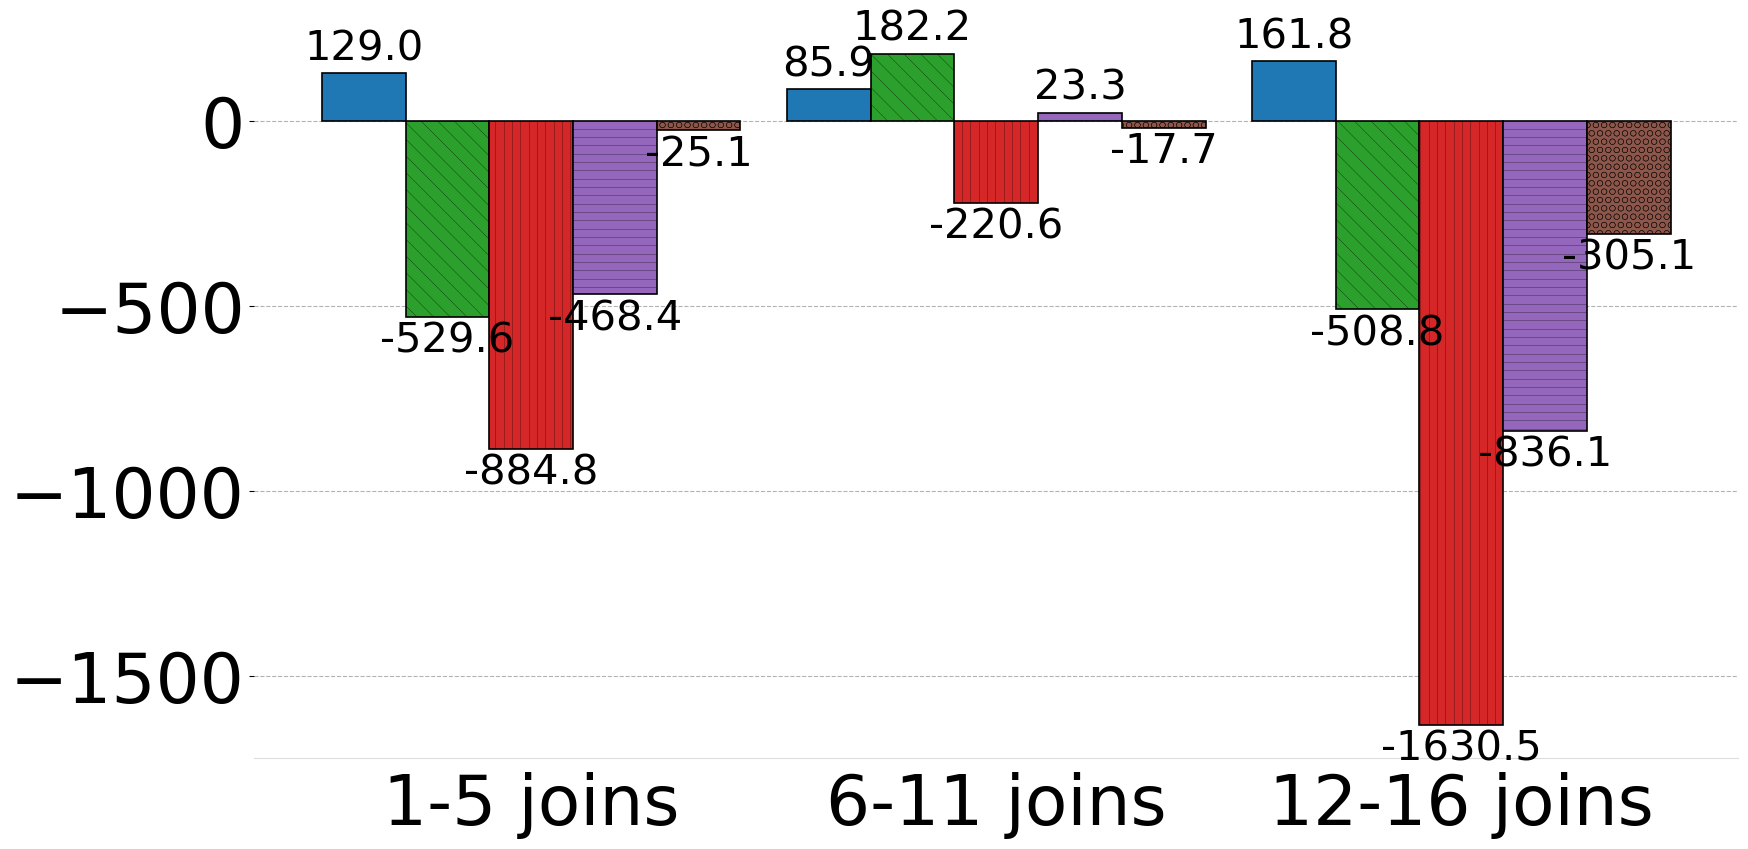

In [15]:
# ## 5. Calculate Binned Regret

import numpy as np

def calculate_binned_regret(ground_truth_latencies, optimizer_data, bins=None):
    """
    Calculates the absolute and relative regret for each optimizer, binned by join complexity.

    Args:
        ground_truth_latencies (dict): Ground truth data.
        optimizer_data (dict): Optimizer decision data.
        bins (list of tuples): Join complexity bins.

    Returns:
        dict: A dictionary with binned regret statistics for each optimizer.
    """
    if bins is None:
        bins = [(1, 5), (6, 11), (12, float('inf'))]

    # Initialize a nested dict to store lists of regret values for each bin
    regret_stats = {
        opt: {
            f"{low}-{high if high != float('inf') else 'inf'} joins": {'absolute': [], 'relative': []}
            for low, high in bins
        }
        for opt in utils.OPTIMIZERS + ["PostgreSQL"]
    }

    # Iterate through every query and its associated optimizer data
    for query, optimizers in optimizer_data.items():
        if query not in ground_truth_latencies:
            continue
            
        join_level = int(query.split('_')[0])
        target_bin_label = None
        for low, high in bins:
            if low <= join_level <= high:
                target_bin_label = f"{low}-{high if high != float('inf') else 'inf'} joins"
                break
        if not target_bin_label:
            continue

        for optimizer_name, selectivities_data in optimizers.items():
            if optimizer_name not in regret_stats:
                continue

            for selectivity, data in selectivities_data.items():
                # --- 1. Get Ground Truth and Optimal Time ---
                ground_truth = ground_truth_latencies.get(query, {}).get(selectivity, {})
                index_time = ground_truth.get('index_scan')
                seq_time = ground_truth.get('seq_scan')
                
                if index_time is None or seq_time is None:
                    continue
                
                time_optimal = min(index_time, seq_time)

                # --- 2. Get Optimizer's Execution Time ---
                optimizer_exec_time = data.get('exec_time')
                
                if optimizer_exec_time is None:
                    continue

                # --- 3. Calculate and Store Regret ---
                # Absolute Regret (in ms)
                absolute_regret = optimizer_exec_time - time_optimal
                regret_stats[optimizer_name][target_bin_label]['absolute'].append(absolute_regret)
                
                # Relative Regret (slowdown factor)
                # Avoid division by zero for very fast optimal queries
                if time_optimal > 0.01: # Epsilon to prevent huge relative regret on tiny queries
                    relative_regret = optimizer_exec_time / time_optimal
                    regret_stats[optimizer_name][target_bin_label]['relative'].append(relative_regret)

    return regret_stats

# --- Run the Binned Regret Calculation ---
if job_optimizer_data and job_latencies:
    print("\n--- Calculating Binned Regret for JOB Workload ---")
    join_bins = [(1, 5), (6, 11), (12, float('inf'))]
    binned_regret = calculate_binned_regret(job_latencies, job_optimizer_data, bins=join_bins)

    # (Optional) Print a summary of the calculated regret statistics
    print("\n--- Summary of Mean Absolute Regret (ms) ---")
    for bin_label in [f"{l}-{h if h != float('inf') else 'inf'} joins" for l, h in join_bins]:
        print(f"\n--- Bin: {bin_label} ---")
        for optimizer, data in binned_regret.items():
            abs_regret_list = data[bin_label]['absolute']
            if abs_regret_list:
                mean_regret = np.mean(abs_regret_list)
                print(f"{optimizer:<12} | Mean Abs. Regret: {mean_regret:8.2f} ms")
else:
    print("Could not calculate regret because data was not loaded.")
    
# ## 6. Visualize Binned Regret

def plot_binned_regret(binned_regret_data, metric='absolute', statistic='mean', save_path=None):
    """
    Generates a polished grouped bar chart for binned regret.

    Args:
        binned_regret_data (dict): The output from calculate_binned_regret.
        metric (str): 'absolute' or 'relative' regret.
        statistic (str): 'mean', 'median', 'max', or 'p95'.
        save_path (str): File path to save the plot.
    """
    # --- 1. Data Preparation ---
    optimizer_order = ['PostgreSQL', 'NEO', 'BAO', 'LOGER', 'FASTgres', 'LERO']
    optimizer_colors = {
        'PostgreSQL': '#1f77b4', 'NEO': '#ff7f0e', 'BAO': '#2ca02c',
        'LOGER': '#d62728', 'FASTgres': '#9467bd', 'LERO': '#8c564b'
    }
    patterns = {
        'PostgreSQL': '', 'NEO': '//', 'BAO': '\\\\', 'LOGER': '||',
        'FASTgres': '--', 'LERO': 'OO'
    }
    plt.rcParams['hatch.linewidth'] = 0.2

    available_optimizers = [
        opt for opt in optimizer_order
        if opt in binned_regret_data and any(binned_regret_data[opt][bin_label][metric] 
                                             for bin_label in binned_regret_data[opt])
    ]
    if not available_optimizers:
        print("No regret data to plot.")
        return
    available_optimizers.remove('NEO')  # Exclude NEO as per previous decisions

    bin_labels = list(binned_regret_data[available_optimizers[0]].keys())
    
    # Compute chosen statistic
    stat_values = {opt: [] for opt in available_optimizers}
    for bin_label in bin_labels:
        for optimizer in available_optimizers:
            values = binned_regret_data[optimizer][bin_label][metric]
            if not values:
                stat_values[optimizer].append(0)
            else:
                if statistic == 'mean':
                    stat_values[optimizer].append(np.mean(values))
                elif statistic == 'median':
                    stat_values[optimizer].append(np.median(values))
                elif statistic == 'max':
                    stat_values[optimizer].append(np.max(values))
                elif statistic == 'p95':
                    stat_values[optimizer].append(np.percentile(values, 95))

    # --- 2. Plotting ---
    x = np.arange(len(bin_labels))
    width = 0.18
    num_optimizers = len(available_optimizers)
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.rcParams.update({'font.size': 24})

    for i, optimizer in enumerate(available_optimizers):
        offset = width * (i - (num_optimizers - 1) / 2)
        bars = ax.bar(
            x + offset,
            stat_values[optimizer],
            width,
            label=optimizer,
            color=optimizer_colors.get(optimizer, 'grey'),
            hatch=patterns.get(optimizer, ''),
            edgecolor='black',
            linewidth=1.2
        )
        fmt = '%.1f' if metric == 'absolute' else '%.1fx'
        ax.bar_label(bars, padding=3, fmt=fmt, fontsize=30)

    # --- 3. Customization ---
    ax.set_ylabel('', fontsize=16, labelpad=0)
    ax.set_xticks(x, [label.replace("_", " ").replace("inf", "16") for label in bin_labels], fontsize=50)
    ax.tick_params(axis='x', length=0, pad=10)
    ax.tick_params(axis='y', labelsize=50)
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')

    # ax.legend(
    #     loc='upper center',
    #     bbox_to_anchor=(0.5, 1.3),
    #     ncol=num_optimizers,
    #     fontsize=26,
    #     handlelength=3.0,
    #     handleheight=1.5,
    #     frameon=True,
    #     facecolor='white',
    #     edgecolor='black',
    #     fancybox=True
    # )

    fig.tight_layout(rect=[0, 0, 1, 0.9])

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=600)
        print(f"Plot saved to: {save_path}")
    
    plt.show()


# --- Generate the Regret Plots ---
if 'binned_regret' in locals():
    if 'Postgres' in binned_regret and 'PostgreSQL' not in binned_regret:
        binned_regret['PostgreSQL'] = binned_regret.pop('Postgres')

    plot_binned_regret(
        binned_regret,
        metric='absolute',
        statistic='mean',
        save_path="plots/4.1/mean_absolute_regret.pdf"
    )

### Experiment 4.2

Analyse the composition of operators selected from each optimizer

- **Optimal Composition**: Break down the composition of physical operators in the optimal plans for the workload.
- **Classic Optimizer Composition**: Analyze the composition of physical operators proposed by the traditional optimizer.
- **LQO Composition**: Compare the composition of physical operators proposed by each LQO.

**Goal**: Understand how the choice of physical operators differs between optimal plans, classic optimizers, and LQOs, and how these choices impact performance."			

In [16]:
OPERATOR_ROOT = os.path.join(BASE_DIR, "4.2")
OPTIMAL_PLANS_DIR = BASE_DIR / "preprocessing/optimal_plans/job"
operator_counts, operator_exec_times = utils.analyze_join_operators(OPERATOR_ROOT,OPTIMAL_PLANS_DIR)
print("Analysis complete. Found data for the following join levels:", sorted(operator_counts.keys()))

Processing main experiment directory...
Analysis complete. Found data for the following join levels: ['10', '11', '12', '13', '14', '16', '17', '18', '19', '20', '21', '23', '28', '4', '5', '6', '7', '8', '9']


In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import os
import numpy as np

def plot_join_operator_composition(operator_counts, execution_times, save_dir="plots/4.2/"):
    """
    Generates final, styled pie charts for specific join levels (5, 7, 12).
    This version is optimized to minimize whitespace, use larger fonts,
    and displays the legend ONLY for the join level 5 plot.
    """
    # --- 1. Setup and Styling ---
    optimizer_order = ["PostgreSQL", "NEO", "BAO", "LOGER", "FASTgres", "LERO"]
    
    join_styles = {
        "Nested Loop": {"color": "#ff9999", "hatch": ""},
        "Hash Join": {"color": "#66b3ff", "hatch": "//"},
        "Merge Join": {"color": "#99ff99", "hatch": ".."}
    }
    
    TITLE_FONTSIZE = 32
    LEGEND_FONTSIZE = 36
    PIE_TEXT_FONTSIZE = 24
    
    os.makedirs(save_dir, exist_ok=True)
    join_levels_to_plot = {5, 7, 12}

    # --- 2. Pre-calculate total execution times for speedup ---
    total_times = defaultdict(lambda: defaultdict(float))
    for (join_level, query_name), optimizers_data in execution_times.items():
        for optimizer, time in optimizers_data.items():
            if time > 0:
                total_times[join_level][optimizer] += time

    # --- 3. Generate a plot for each specified join level ---
    for join_level_str in sorted(operator_counts.keys()):
        join_level = int(join_level_str)
        if join_level not in join_levels_to_plot:
            continue

        optimizers_data = operator_counts[join_level_str]
        ordered_optimizers = [opt for opt in optimizer_order if opt in optimizers_data]
        num_optimizers = len(ordered_optimizers)
        if num_optimizers == 0:
            continue
        
        fig, axes = plt.subplots(1, num_optimizers, figsize=(4 * num_optimizers, 4.5))
        if num_optimizers == 1:
            axes = [axes]
        
        # --- 4. Plot each pie chart ---
        for ax, optimizer in zip(axes, ordered_optimizers):
            join_counts = optimizers_data.get(optimizer, {})
            pie_data = {op: join_counts.get(op, 0) for op in join_styles}
            pie_labels = [op for op, size in pie_data.items() if size > 0]
            pie_sizes = [size for size in pie_data.values() if size > 0]
            
            if not pie_sizes:
                ax.text(0.5, 0.5, "No Joins\nFound", ha='center', va='center', fontsize=PIE_TEXT_FONTSIZE)
            else:
                pie_colors = [join_styles[op]["color"] for op in pie_labels]
                pie_hatches = [join_styles[op]["hatch"] for op in pie_labels]
                
                autopct_func = lambda p: f'{p:.1f}%' if p > 10 else ''
                
                ax.pie(pie_sizes, colors=pie_colors, hatch=pie_hatches, 
                       startangle=90, wedgeprops={'edgecolor': 'black'},
                       autopct=autopct_func,
                       pctdistance=0.6,
                       textprops={'fontsize': PIE_TEXT_FONTSIZE, 'fontweight': 'bold'})
            
            ax.set_aspect('equal')
            
            title_str = f"{optimizer}"
            if optimizer != "PostgreSQL":
                pg_time = total_times.get(join_level, {}).get("PostgreSQL", 0)
                lqo_time = total_times.get(join_level, {}).get(optimizer, 0)
                speedup = pg_time / lqo_time if pg_time > 0 and lqo_time > 0 else 0
                title_str += f"\nSpeedup: {speedup:.2f}x" if speedup > 0 else "\nSpeedup: N/A"
            
            ax.set_title(title_str, fontsize=TITLE_FONTSIZE, pad=8)
        
        # Adjust horizontal spacing between subplots
        plt.subplots_adjust(wspace=0.01)

        # --- MODIFICATION: Conditional Legend and Layout ---
        # Only create the legend and adjust the layout for it on the join level 5 plot.
        if join_level == 5:
            legend_handles = [
                mpatches.Patch(facecolor=style["color"], hatch=style["hatch"], label=op, edgecolor='black')
                for op, style in join_styles.items()
            ]
            fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.21),
                       ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True, facecolor='white', edgecolor='black')
            
            # Use a layout that reserves space for the legend
            plt.tight_layout(rect=[0, 0, 1, 0.93]) 
        else:
            # For all other plots, use a standard tight layout to fill the figure
            plt.tight_layout()
        
        plot_path = os.path.join(save_dir, f"join_level_{join_level}.pdf") 
        print(f"Saving styled plot for join level {join_level}: {plot_path}")
        
        plt.savefig(plot_path, bbox_inches='tight')
        plt.show()
        # plt.close(fig)


Generating plots...
Saving styled plot for join level 12: plots/4.2/join_level_12.pdf


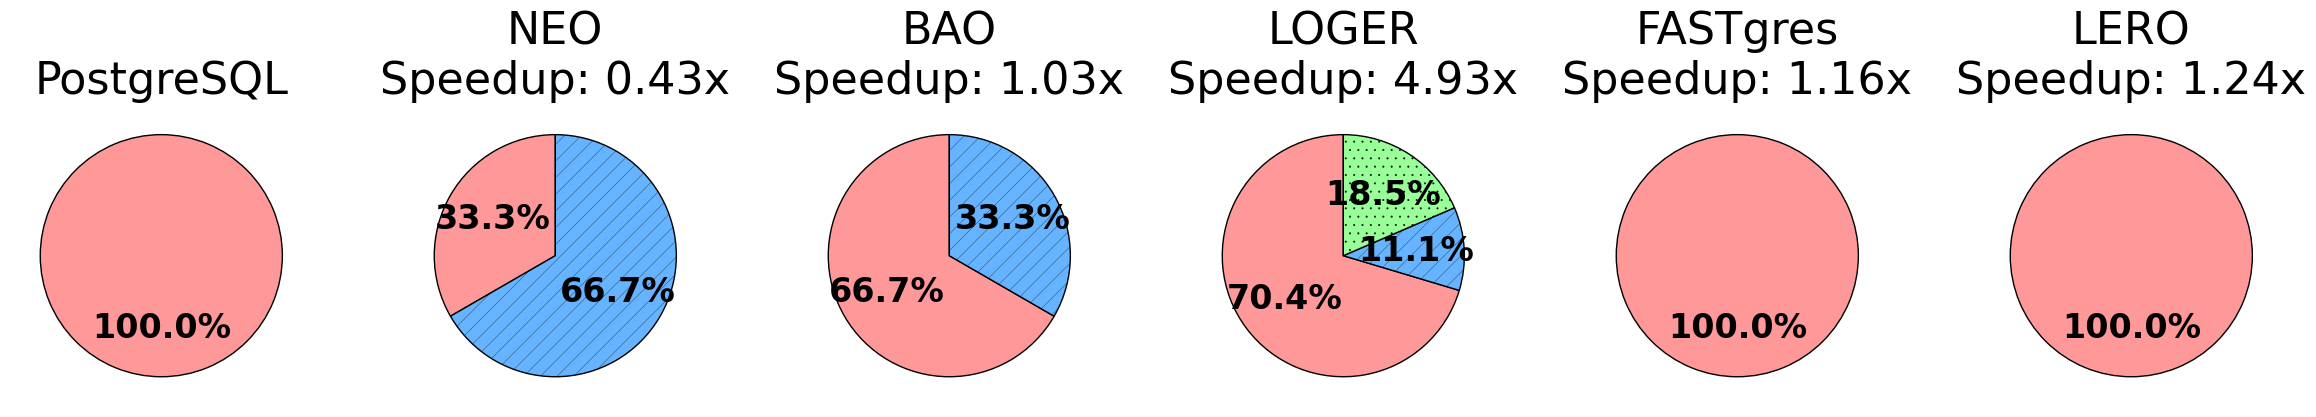

Saving styled plot for join level 5: plots/4.2/join_level_5.pdf


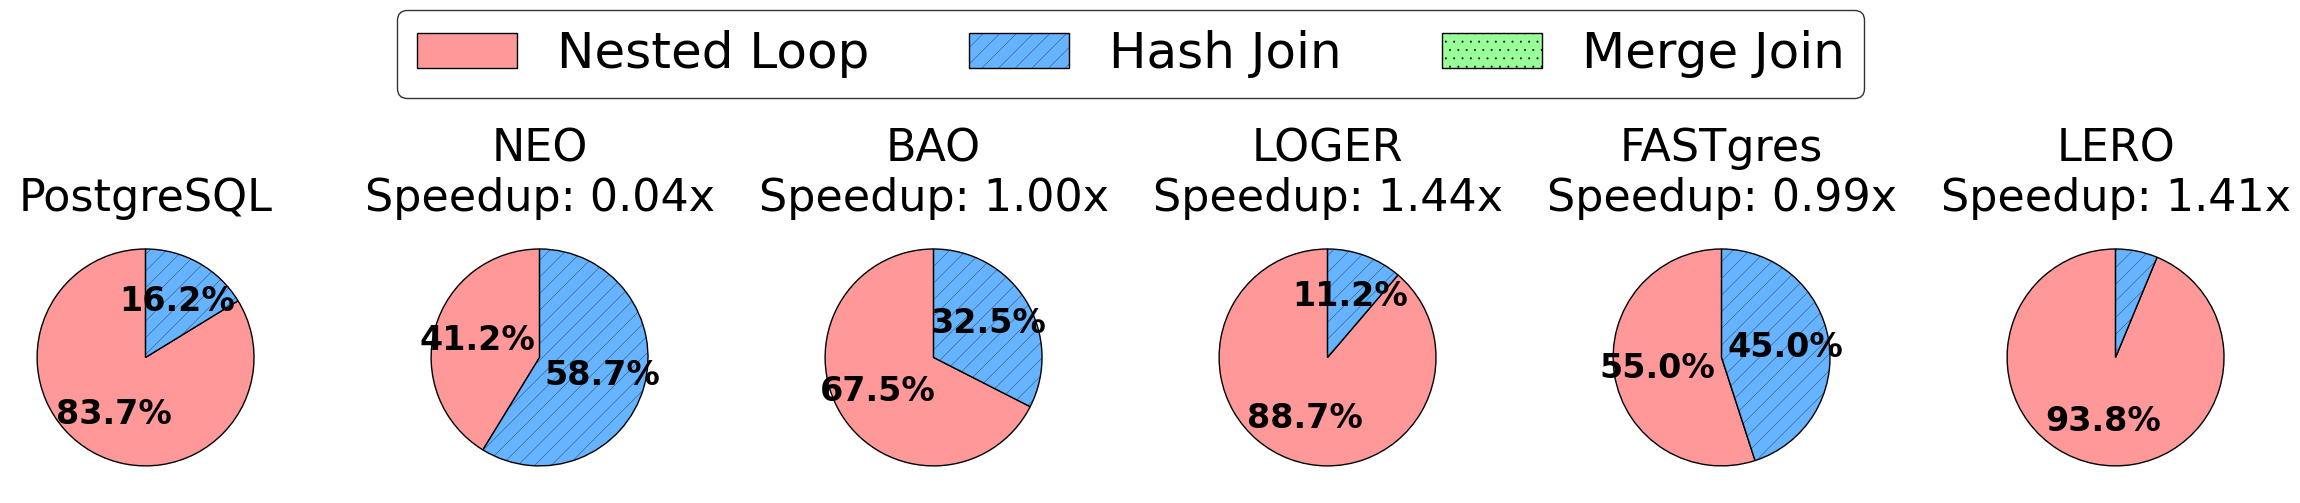

Saving styled plot for join level 7: plots/4.2/join_level_7.pdf


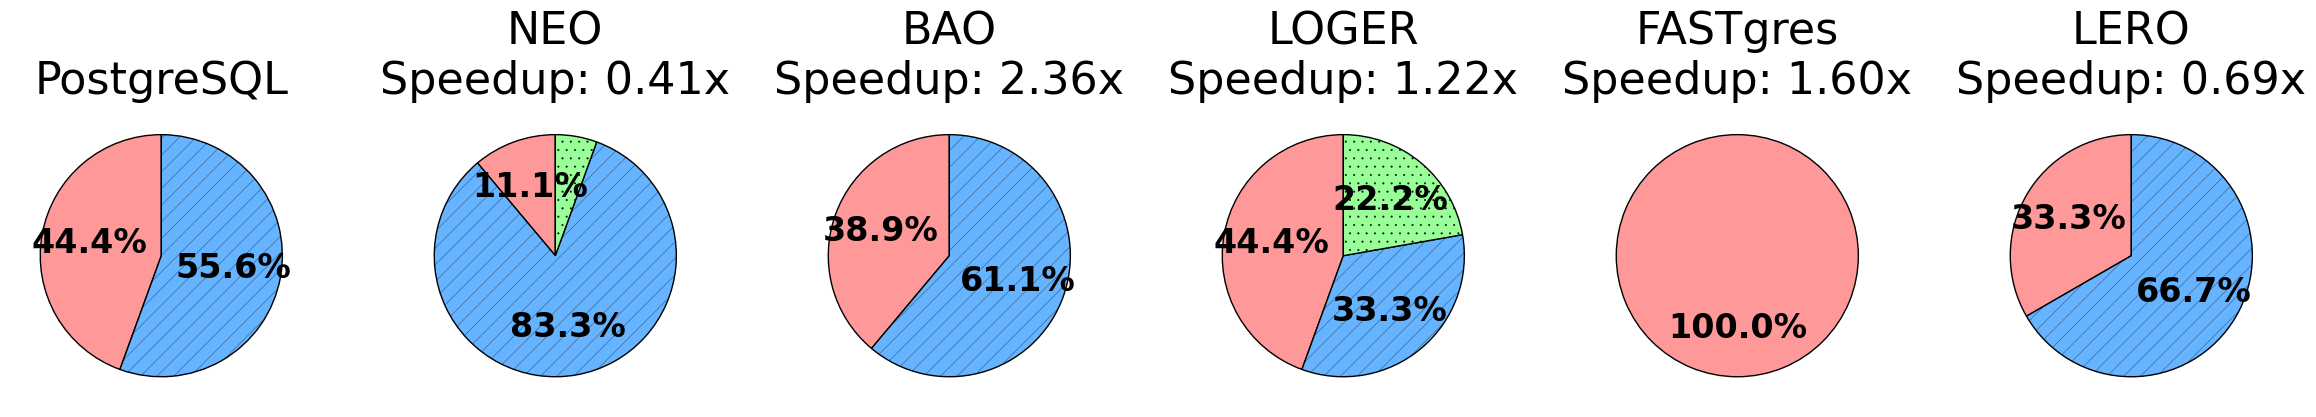


All plots generated.


In [18]:
print("\nGenerating plots...")

plot_join_operator_composition(
    operator_counts,
    operator_exec_times,save_dir="plots/4.2/"
)

print("\nAll plots generated.")

### Experiment 4.3

- **Predicted vs. Actual Latency**: Measure the LQO’s predicted latency for plans using forced join or scan operators and compare it to the actual execution latency.
- **Bias Detection**: Analyze whether the LQO systematically overestimates or underestimates the latency of specific operators.

**Goal**: Understand the accuracy and reliability of the LQO's latency predictions for different operators, and identify any inherent biases that may impact the quality of the generated query plans.

In [19]:
EXP_ROOT = os.path.join(BASE_DIR, "4.3")

print(f"Collecting data for Experiment 4.3 from: {EXP_ROOT}")
df_metrics = utils.collect_prediction_vs_actual_metrics(EXP_ROOT)

if df_metrics.empty:
    print("Data collection complete, but no data was found. Please check paths and file contents.")

In [20]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

def create_prediction_vs_actual_legend(optimizer_styles, save_path):
    """
    Creates a standalone legend for prediction vs. actual latency plots.
    
    Args:
        optimizer_styles (dict): Mapping optimizer names to color/hatch/style dicts.
        save_path (str): Path to save the legend PDF.
    """
    fig_legend = plt.figure(figsize=(10, 2))
    
    legend_handles = [
        Line2D([0], [0], color=optimizer_styles['Postgres']['color'], lw=2, marker='o', markersize=8, label='Postgres (Runtime)'),
        Line2D([0], [0], color=optimizer_styles['BAO']['color'], lw=2, linestyle='--', marker='s', markersize=8, label='BAO (Runtime)'),
        Line2D([0], [0], color=optimizer_styles['LOGER']['color'], lw=2, linestyle='--', marker='^', markersize=8, label='LOGER (Runtime)'),
        Line2D([0], [0], color=optimizer_styles['BAO']['color'], lw=0, marker='x', markersize=12, label='BAO (Prediction)'),
        Line2D([0], [0], color=optimizer_styles['LOGER']['color'], lw=0, marker='x', markersize=12, label='LOGER (Prediction)'),
        Line2D([0], [0], color=optimizer_styles['NEO']['color'], lw=0, marker='x', markersize=12, label='NEO (Prediction)')
    ]

    fig_legend.legend(handles=legend_handles, loc='center', ncol=len(legend_handles), fontsize=20, handlelength=3.0)
    plt.axis('off')
    fig_legend.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig_legend.savefig(save_path, bbox_inches='tight', dpi=600)
    plt.close(fig_legend)
    print(f"Legend saved to: {save_path}")


# --- Example Usage ---
optimizer_styles = {
    'Postgres': {'color': '#1f77b4', 'hatch': ''},
    'BAO': {'color': '#d62728', 'hatch': '///'},
    'LOGER': {'color': '#2ca02c', 'hatch': '\\\\\\'},
    'NEO': {'color': '#ff7f0e', 'hatch': '...'}
}

create_prediction_vs_actual_legend(optimizer_styles, "plots/4.3/prediction_actual_legend.pdf")

Legend saved to: plots/4.3/prediction_actual_legend.pdf


In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import os

def plot_prediction_vs_actual(df, save_dir="plots/4.3/"):
    """
    Creates a grid of plots for specific join levels (5, 9, 10, 21),
    saving them as PDFs with a custom legend including hatches.
    
    Args:
        df (pd.DataFrame): The DataFrame with prediction and actual metrics.
        save_dir (str): Directory to save the output plots.
    """
    if df.empty:
        print("DataFrame is empty. No data to plot."); return

    os.makedirs(save_dir, exist_ok=True)

    # --- 1. Define Styling ---
    optimizer_styles = {
        'Postgres': {'color': '#1f77b4', 'hatch': ''},
        'BAO': {'color': '#d62728', 'hatch': '///'},
        'LOGER': {'color': '#2ca02c', 'hatch': '\\\\\\'},
        'NEO': {'color': '#ff7f0e', 'hatch': '...'}
    }
    
    # Define which join levels are needed for the LaTeX figure
    join_levels_to_plot = {5, 9, 10, 21}
    # legend_join_levels = {5, 9}

    # --- 2. Main Plotting Loop ---
    for join_level in sorted(df['join_level'].unique()):
        # Only generate plots specified in the LaTeX code
        if join_level not in join_levels_to_plot:
            continue
            
        level_data = df[df['join_level'] == join_level].copy()
        fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
        plt.rcParams.update({'font.size': 24})
        fig.tight_layout(pad=1.5)

        for j, join_type in enumerate(['hashjoin', 'mergejoin', 'nestloop']):
            ax = axes[j]
            type_data = level_data[level_data['join_type'] == join_type].sort_values('latency').reset_index(drop=True)
            
            if type_data.empty:
                ax.text(0.5, 0.5, "No Data", ha='center', va='center'); ax.set_title(f'{join_type.capitalize()}', fontsize=60); continue

            # Plot actual runtimes (lines)
            ax.plot(type_data.index, type_data['latency'], marker='o', markersize=10, linestyle='-', color=optimizer_styles['Postgres']['color'])
            ax.plot(type_data.index, type_data['bao_latency'], marker='s', markersize=10, linestyle='--', color=optimizer_styles['BAO']['color'])
            ax.plot(type_data.index, type_data['loger_latency'], marker='^', markersize=10, linestyle='--', color=optimizer_styles['LOGER']['color'])

            # Plot predicted latencies (scatter 'x' markers)
            ax.scatter(type_data.index, type_data['bao_prediction'], color=optimizer_styles['BAO']['color'], marker='x', s=100)
            ax.scatter(type_data.index, type_data['loger_prediction'], color=optimizer_styles['LOGER']['color'], marker='x', s=100)
            ax.scatter(type_data.index, type_data['neo_prediction'], color=optimizer_styles['NEO']['color'], marker='x', s=100)

            ax.set_yscale('log'); ax.grid(True, which="major", ls="--", alpha=0.6); ax.set_xticklabels([]); ax.set_xlabel('')
            ax.set_title(f'{join_type.capitalize()}', fontsize=60)
            ax.tick_params(axis='y', labelsize=60)
            if j == 0: ax.set_ylabel('', fontsize=16)
        
        # # --- 3. Custom Legend only for 5 and 9 joins ---
        # if join_level in legend_join_levels:
        #     legend_handles = [
        #         Line2D([0], [0], color=optimizer_styles['Postgres']['color'], lw=2, marker='o', markersize=8, label='Postgres (Runtime)'),
        #         Line2D([0], [0], color=optimizer_styles['BAO']['color'], lw=2, linestyle='--', marker='s', markersize=8, label='BAO (Runtime)'),
        #         Line2D([0], [0], color=optimizer_styles['LOGER']['color'], lw=2, linestyle='--', marker='^', markersize=8, label='LOGER (Runtime)'),
        #         Line2D([0], [0], color=optimizer_styles['BAO']['color'], lw=0, marker='x', markersize=12, label='BAO (Prediction)'),
        #         Line2D([0], [0], color=optimizer_styles['LOGER']['color'], lw=0, marker='x', markersize=12, label='LOGER (Prediction)'),
        #         Line2D([0], [0], color=optimizer_styles['NEO']['color'], lw=0, marker='x', markersize=12, label='NEO (Prediction)')
        #     ]
        #     fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.15),
        #                ncol=3, fontsize=28, handlelength=3.0)

        # --- 4. Save as PDF ---
        fig.tight_layout(rect=[0, 0, 1, 0.9])
        plot_path = os.path.join(save_dir, f"join_level_{join_level}_predictions.pdf")
        print(f"Saving LaTeX plot to: {plot_path}")
        plt.savefig(plot_path, bbox_inches='tight')
        plt.show()


Generating prediction vs. actual latency plots...
Saving LaTeX plot to: plots/4.3/join_level_5_predictions.pdf


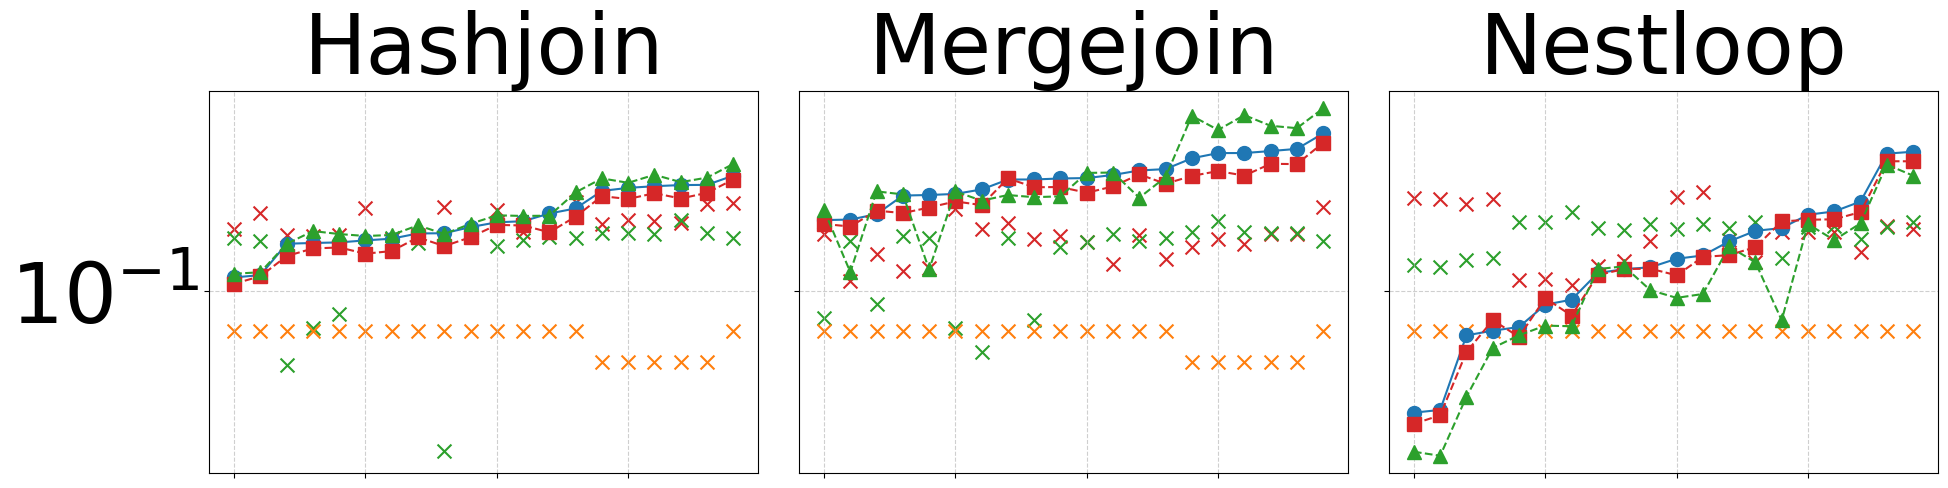

Saving LaTeX plot to: plots/4.3/join_level_9_predictions.pdf


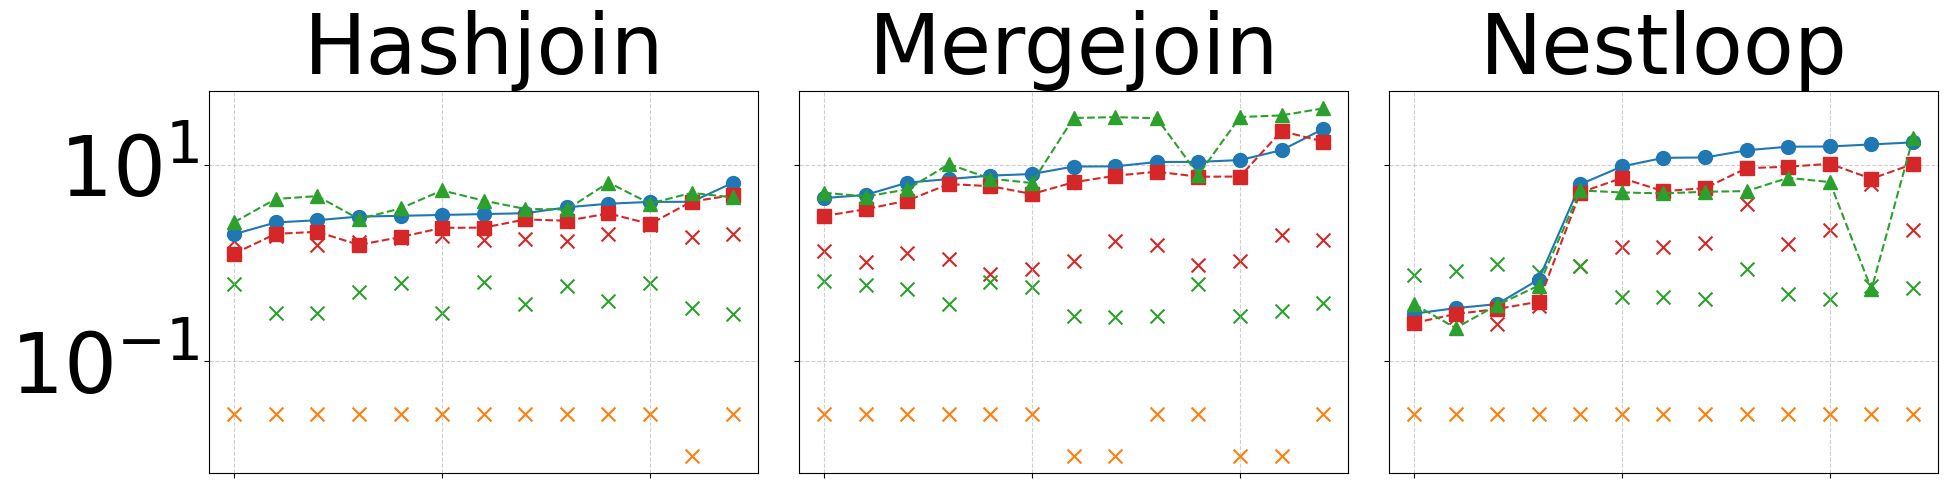

Saving LaTeX plot to: plots/4.3/join_level_10_predictions.pdf


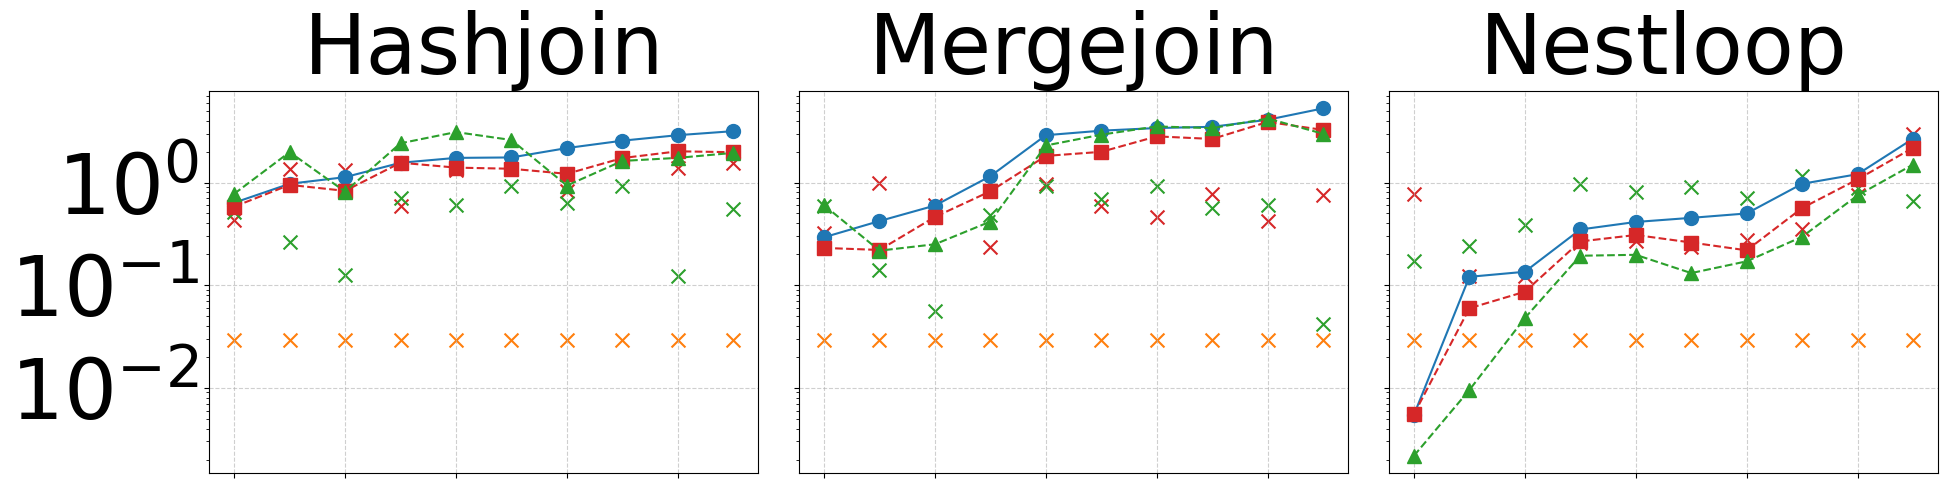

Saving LaTeX plot to: plots/4.3/join_level_21_predictions.pdf


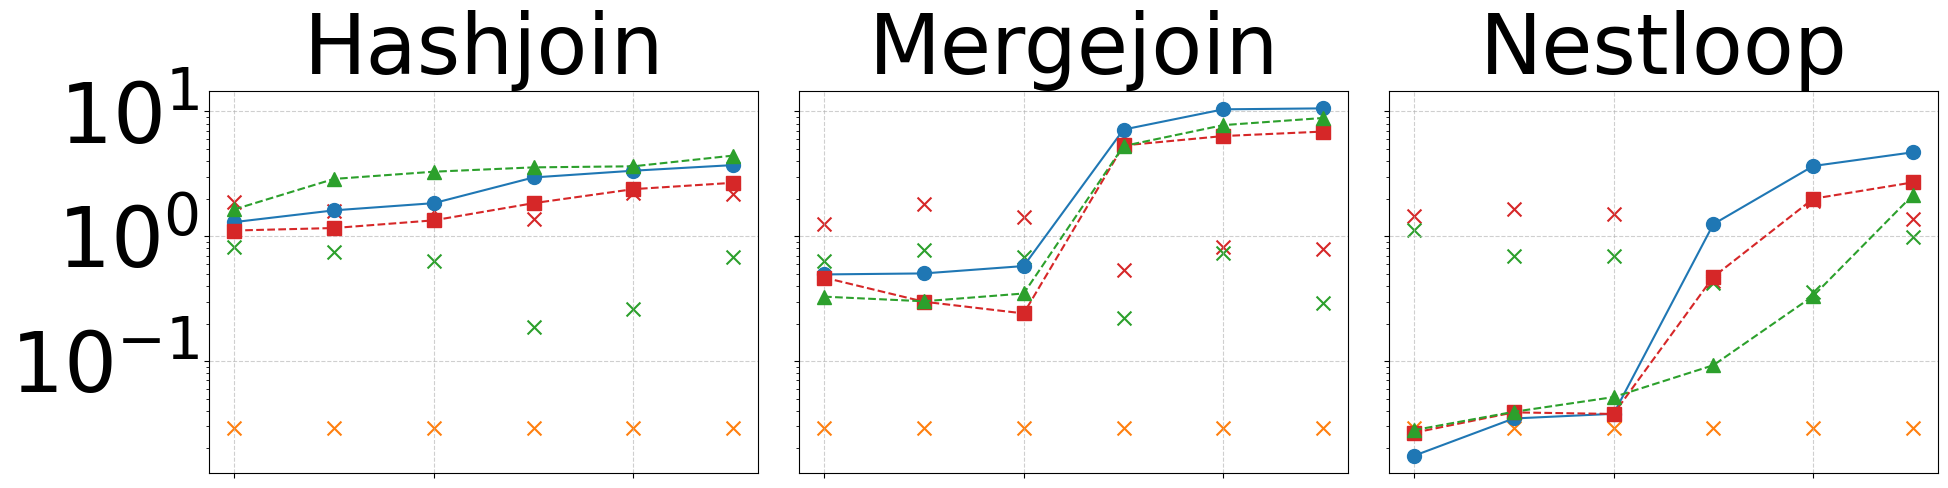


All plots generated.


In [22]:
print("\nGenerating prediction vs. actual latency plots...")
plot_prediction_vs_actual(df_metrics)
print("\nAll plots generated.")

In [23]:
# ## (New Cell) - Calculate Over/Under Prediction Errors by Join Operator

import numpy as np
import pandas as pd

def calculate_errors_by_join_operator(df):
    """
    Calculates the magnitude and frequency of over- and under-predictions,
    grouped by the join operator type.

    Args:
        df (pd.DataFrame): The DataFrame from collect_prediction_vs_actual_metrics.

    Returns:
        dict: A nested dictionary with error statistics for each optimizer and join type.
    """
    optimizers = ['BAO', 'LOGER', 'NEO']
    join_types = ['hashjoin', 'mergejoin', 'nestloop']
    
    error_stats = {
        opt: {
            join_type: {'over_errors': [], 'under_errors': []}
            for join_type in join_types
        }
        for opt in optimizers
    }

    for _, row in df.iterrows():
        actual_latency = row['latency']
        if pd.isna(actual_latency) or actual_latency <= 0.001:
            continue

        join_type = row['join_type']
        if join_type not in join_types:
            continue

        for opt in optimizers:
            predicted_latency = row[f'{opt.lower()}_prediction']
            if pd.isna(predicted_latency) or predicted_latency <= 0:
                continue

            if predicted_latency > actual_latency:
                error_magnitude = predicted_latency / actual_latency
                error_stats[opt][join_type]['over_errors'].append(error_magnitude)
            elif actual_latency > predicted_latency:
                error_magnitude = actual_latency / predicted_latency
                error_stats[opt][join_type]['under_errors'].append(error_magnitude)
            
    return error_stats

# --- Run the new calculation ---
print("Calculating over/under prediction errors by join operator...")
# df_metrics = collect_prediction_vs_actual_metrics(your_root_dir) 
errors_by_operator = calculate_errors_by_join_operator(df_metrics)
print("Calculation complete.")

Calculating over/under prediction errors by join operator...
Calculation complete.


Plot saved to: plots/4.3/final_prediction_bias_inline.pdf


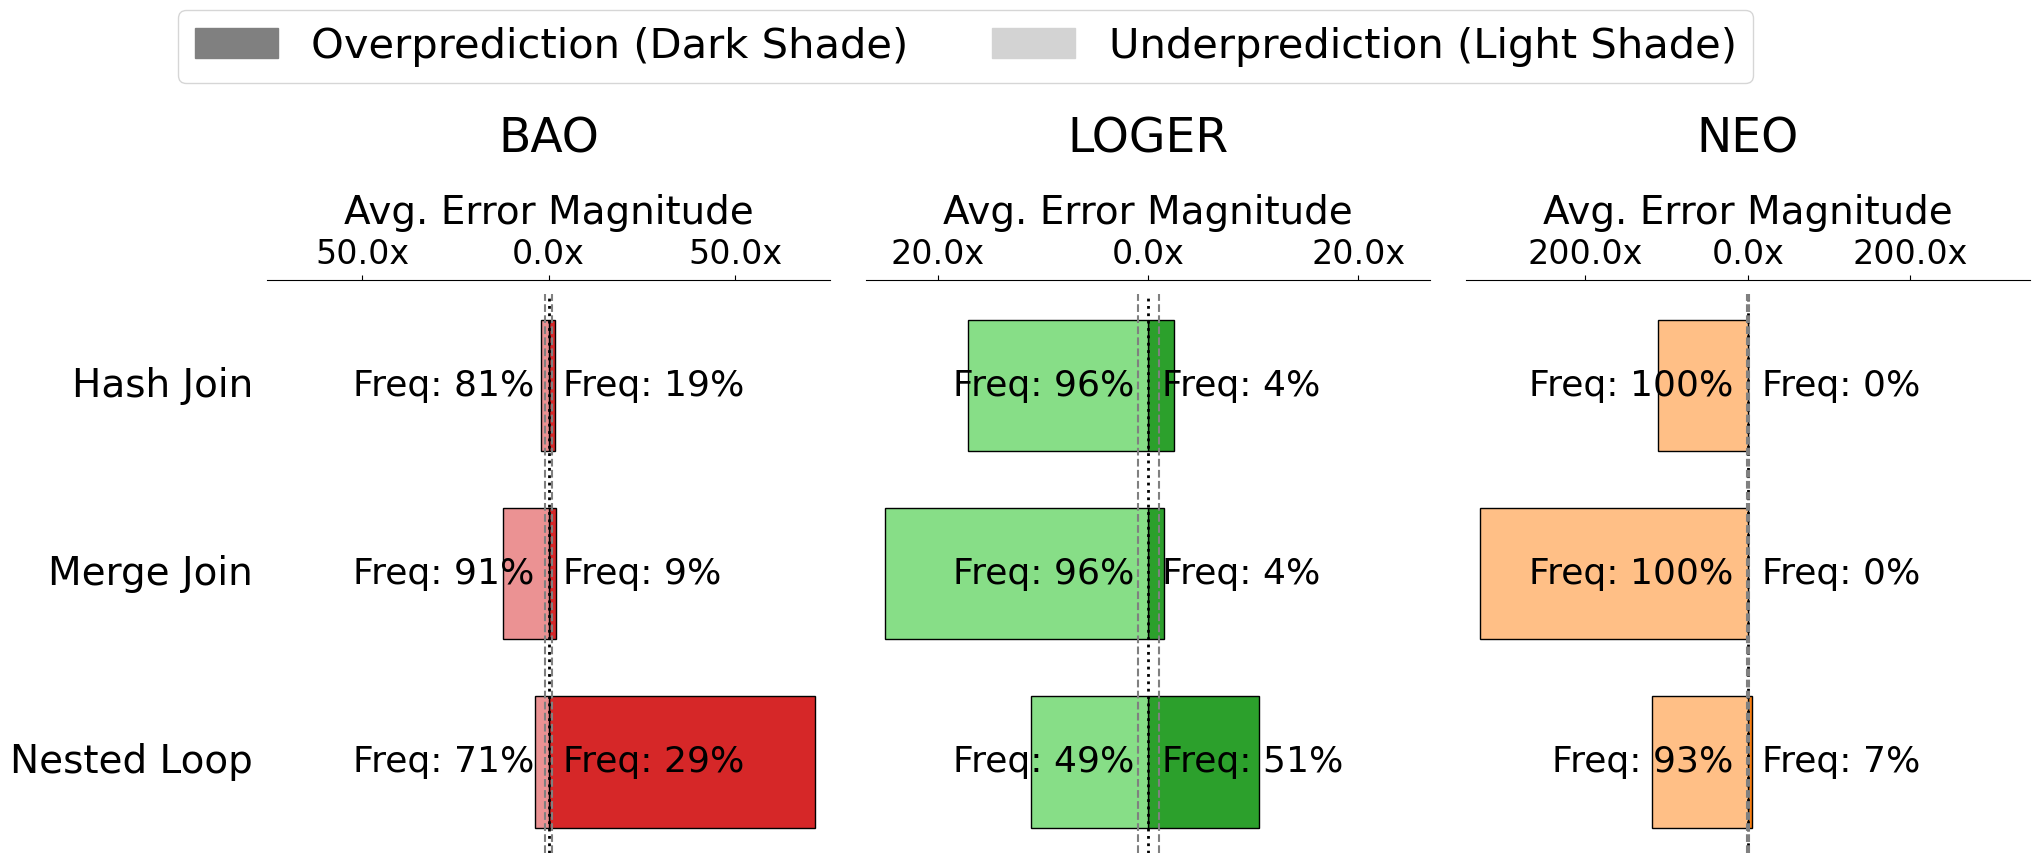

In [24]:
# ## (New Cell) - Final Visualization with Inline Frequency Labels

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def lighten_color(color, amount=0.5):
    """Lighter color version for underprediction bars."""
    import colorsys
    c = plt.cm.colors.to_rgb(color)
    c = colorsys.rgb_to_hls(*c)
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_final_prediction_bias_inline_labels(error_data, save_path="plots/4.3/final_prediction_bias_inline.pdf"):
    """
    Generates the final diverging bar chart with inline "Freq:" labels
    next to the percentage values for maximum clarity.
    """
    # --- 1. Setup ---
    optimizers = ['BAO', 'LOGER', 'NEO']
    join_types = ['Hash Join', 'Merge Join', 'Nested Loop']
    y_pos = np.arange(len(join_types))
    
    optimizer_colors = {'BAO': '#d62728', 'LOGER': '#2ca02c', 'NEO': '#ff7f0e'}
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 9), sharey=True)
    plt.rcParams.update({'font.size': 24})

    # --- 2. Create a plot for each optimizer ---
    for i, optimizer in enumerate(optimizers):
        ax = axes[i]
        mean_overs, mean_unders = [], []
        freq_over_str, freq_under_str = [], []

        for join_type_raw in ['hashjoin', 'mergejoin', 'nestloop']:
            data = error_data[optimizer][join_type_raw]
            over_errors, under_errors = data['over_errors'], data['under_errors']
            
            count_over, count_under = len(over_errors), len(under_errors)
            total_count = count_over + count_under
            
            mean_overs.append(np.mean(over_errors) if over_errors else 0)
            mean_unders.append(-np.mean(under_errors) if under_errors else 0)
            
            # --- CHANGE IS HERE: Prepend "Freq:" to the string ---
            freq_over_str.append(f'Freq: {(count_over / total_count * 100):.0f}%' if total_count > 0 else '')
            freq_under_str.append(f'Freq: {(count_under / total_count * 100):.0f}%' if total_count > 0 else '')

        # --- 3. Plotting the bars ---
        dark_color = optimizer_colors[optimizer]
        light_color = lighten_color(dark_color, 0.5)

        ax.barh(y_pos, mean_overs, height=0.7, color=dark_color, edgecolor='black')
        ax.barh(y_pos, mean_unders, height=0.7, color=light_color, edgecolor='black')
        
        # --- 4. Formatting ---
        ax.set_title(optimizer, fontsize=34, pad=30)
        ax.axvline(0, color='black', linestyle=':', linewidth=2)
        ax.axvline(1, color='grey', linestyle='--', linewidth=1.5)
        ax.axvline(-1, color='grey', linestyle='--', linewidth=1.5)
        
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.set_xlabel('Avg. Error Magnitude', fontsize=28, labelpad=10)

        ax.spines['top'].set_position(('outward', 10))
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        max_lim = max(ax.get_xlim()[1], abs(ax.get_xlim()[0]), 1.5)
        ax.set_xlim(-max_lim, max_lim)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{abs(x):.1f}x'))
        
        # --- 5. Add custom text labels for frequency ---
        text_offset_x = max_lim * 0.05 # Position labels close to the center
        for j in range(len(join_types)):
            if i == 0:
                ax.text(-max_lim * 1.05, j, f'{join_types[j]}', ha='right', va='center', fontsize=28)
            
            # Place the newly formatted frequency labels
            ax.text(text_offset_x, j, freq_over_str[j], ha='left', va='center', fontsize=26)
            ax.text(-text_offset_x, j, freq_under_str[j], ha='right', va='center', fontsize=26)

    # --- 6. Final Touches ---
    axes[0].set_yticks([])
    axes[0].invert_yaxis()
    
    handles = [mpatches.Patch(color='grey', label='Overprediction (Dark Shade)'),
               mpatches.Patch(color='lightgrey', label='Underprediction (Light Shade)')]
    fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=30, frameon=True)
    
    fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=600)
        print(f"Plot saved to: {save_path}")
    plt.show()

# --- Generate the plot ---
if 'errors_by_operator' in locals():
    plot_final_prediction_bias_inline_labels(errors_by_operator)
else:
    print("Error data not found. Please run the calculation cell first.")

### Experiment 4.4

Exam the relationship between plan embeddings and plan quality.

Train: JOB

Test: JOB ran twice on each LQO. Once with LQO-generated plans and once with PostgreSQL gennerated plans.

For both executions per query, we store the embeddings that are generated within the confines of the LQO. 

Later, we compare per query the 2 query plans by a) their cosine distance vs their relative difference in execution latency and b) where each query plan lies within the embedding space

In [25]:
# NOTE: The data source for this analysis is the 4.2 directory.

EXP_BASE_DIR = REPO_ROOT / "experiments/experiment4"
EXP_ROOT = EXP_BASE_DIR / "4.4"
PLOTS_DIR = EXP_BASE_DIR / "plots/4.4"
# Load and process all the data from the generated files.
print(f"Loading data from workload directory: {EXP_ROOT}")
analysis_df = utils.load_embedding_analysis_data(EXP_ROOT)
print(f"Data loaded. Found {len(analysis_df)} records for analysis.")
print("\nAnalyzing embedding distances and speedups...")
if not analysis_df.empty:
    # Print a high-level summary of the results.
    print("\n" + "="*30)
    print("High-level analysis of embedding distances and speedups:")
    print("="*30 + "\n")
    
    print("\nDetailed Analysis Results:")
    print(analysis_df.describe())

    print(analysis_df.head())

Loading data from workload directory: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/4.4
Found 113 queries with BAO results to analyze.


Processing Queries:   0%|          | 0/113 [00:00<?, ?it/s]

Processing Queries: 100%|██████████| 113/113 [00:00<00:00, 2033.89it/s]

Data loaded. Found 113 records for analysis.

Analyzing embedding distances and speedups...

High-level analysis of embedding distances and speedups:


Detailed Analysis Results:
       embedding_distance  speedup_factor    bao_time_ms    pg_time_ms
count        1.130000e+02      113.000000     113.000000    113.000000
mean         1.276756e-14        1.044533    3938.884062   2650.390407
std          5.997810e-15        0.596402   20176.734592   7046.897584
min          3.330669e-15        0.128975      22.057000     17.016000
25%          8.215650e-15        0.839383     205.388000    164.625000
50%          1.154632e-14        0.974308     561.519000    423.308000
75%          1.565414e-14        1.017073    2064.543000   2190.184000
max          3.708145e-14        4.060289  205824.297000  61940.869000
  query_name run_id  embedding_distance  speedup_factor  bao_time_ms  \
0        16b   run1        9.658940e-15        3.210087     5989.336   
1        13a   run1        6.106227e-1

In [26]:
# NOTE: The data source for this analysis is the 4.2 directory.
EXP_BASE_DIR = REPO_ROOT / "experiments/experiment4"
EXP_ROOT = EXP_BASE_DIR / "4.4"
PLOTS_DIR = EXP_BASE_DIR / "plots/4.4"
from scipy.stats import gmean
# Load and process all the data from the generated files.
# Load data for all optimizers found in the base directory
df_all = utils.load_all_optimizer_data(EXP_ROOT)

if not df_all.empty:
    # df_all.dropna(inplace=True)

    print("\n" + "="*50)
    print("--- Overall Analysis Summary ---")
    print(f"Total valid query runs analyzed across all optimizers: {len(df_all)}")
    
    # Display summary statistics for each optimizer
    summary = df_all.groupby('optimizer').agg(
        num_queries=('query_name', 'count'),
        median_distance=('embedding_distance', 'median'),
        avg_speedup=('speedup_factor', gmean),
        win_rate=('speedup_factor', lambda x: (x > 1.0).mean())
    ).reset_index()
    
    summary['win_rate'] = summary['win_rate'].apply(lambda x: f"{x:.1%}")
else:
    print("\nNo valid data was loaded. Please check the BASE_EXPERIMENT_DIR path and ensure optimizer subdirectories exist.")

Starting recursive search for optimizer data in: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/4.4

--- Searching for NEO results... ---
Found 113 queries with NEO results to analyze.


Processing NEO:   0%|          | 0/113 [00:00<?, ?it/s]

Processing NEO: 100%|██████████| 113/113 [00:00<00:00, 2185.07it/s]



--- Searching for BAO results... ---
Found 113 queries with BAO results to analyze.


Processing BAO: 100%|██████████| 113/113 [00:00<00:00, 2032.64it/s]



--- Searching for LERO results... ---
Found 113 queries with LERO results to analyze.


Processing LERO: 100%|██████████| 113/113 [00:00<00:00, 3648.40it/s]


--- Searching for LOGER results... ---


Found 339 queries with LOGER results to analyze.


Processing LOGER: 100%|██████████| 339/339 [00:00<00:00, 2310.52it/s]



--- Searching for FASTgres results... ---
No 'FASTgres' subdirectories found. Skipping.

--- Overall Analysis Summary ---
Total valid query runs analyzed across all optimizers: 642


In [27]:
# plots.plot_divergence_final(df_all, PLOTS_DIR)

In [28]:
from matplotlib.ticker import FuncFormatter, MaxNLocator # Import MaxNLocator
import seaborn as sns

def plot_divergence_scatter_row_zoomed(df, output_dir):
    """
    Creates and saves a single figure with intelligently zoomed scatter plots for
    each optimizer, arranged side-by-side in one row.
    """
    if df.empty:
        print("Cannot plot, DataFrame is empty.")
        return

    os.makedirs(output_dir, exist_ok=True)

    # --- Data Preparation ---
    df['speedup_log2'] = np.log2(df['speedup_factor'])
    df['Result'] = np.where(df['speedup_log2'] >= 0, 'Speedup', 'Slowdown')
    
    palette = {'Speedup': '#2ca02c', 'Slowdown': '#d62728'}
    optimizers = df['optimizer'].unique()
    optimizers = [opt for opt in ['NEO', 'BAO', 'LOGER', 'LERO'] if opt in optimizers]
    n_opts = len(optimizers)

    # --- Plot Setup ---
    fig, axes = plt.subplots(1, n_opts, figsize=(6 * n_opts, 6), sharey=True)
    if n_opts == 1:
        axes = [axes] # Ensure axes is always a list to iterate over

    # --- Intelligent Zooming & Formatting ---
    # Define the quantile range to focus on (e.g., from 2% to 98%)
    q_low, q_high = 0.02, 0.98
    
    # Calculate GLOBAL y-limits for a consistent, shared y-axis zoom
    global_ylims = df['speedup_log2'].quantile([q_low, q_high])
    y_padding = (global_ylims.iloc[1] - global_ylims.iloc[0]) * 0.1
    final_ylim = (global_ylims.iloc[0] - y_padding, global_ylims.iloc[1] + y_padding)
    
    # Define y-axis formatter
    def log2_to_factor(x, pos):
        val = 2**x
        if val < 0.001: return f"{val:.1e}x"
        return f"{val:.2g}x"
    formatter = FuncFormatter(log2_to_factor)

    # X-axis formatter for scientific notation below 0.1
    def x_scientific_formatter(x, pos):
        return f"{x:.1e}" if x < 0.1 else f"{x:.2f}"

    for ax, opt in zip(axes, optimizers):
        df_opt = df[df['optimizer'] == opt].copy()
        if df_opt.empty:
            continue

        # Scatter plot
        sns.scatterplot(
            data=df_opt, x='embedding_distance', y='speedup_log2',
            hue='Result', palette=palette, alpha=0.7, edgecolor='w',
            s=100, ax=ax, legend=False
        )

        # Calculate LOCAL x-limits for individual plot zooming
        xlims = df_opt['embedding_distance'].quantile([q_low, q_high])
        x_padding = (xlims.iloc[1] - xlims.iloc[0]) * 0.1
        ax.set_xlim(xlims.iloc[0] - x_padding, xlims.iloc[1] + x_padding)
        # Apply the global y-limit
        ax.set_ylim(final_ylim)

        # Reference lines and grid
        ax.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
        median_dist = df_opt['embedding_distance'].median()
        ax.axvline(median_dist, color='blue', linestyle=':', linewidth=2, alpha=0.8)
        ax.grid(True, linestyle='--', alpha=0.6)

        # Labels, Title, and Ticks
        ax.set_title(opt, fontsize=32)
        ax.set_xlabel('', fontsize=16)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4, integer=False))
        ax.tick_params(axis='both', labelsize=30)

    # Set shared y-axis label and formatting only on the first plot
    axes[0].set_ylabel('', fontsize=16)
    axes[0].yaxis.set_major_locator(MaxNLocator(nbins=6, prune='both'))
    axes[0].yaxis.set_major_formatter(formatter)

    # --- Final Touches ---
    # Shared legend
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=color, markersize=30)
               for color in ['#2ca02c', '#d62728']]
    labels = ['Speedup (≥ 1x)', 'Slowdown (< 1x)']
    # Increase legend marker size for better visibility
    fig.legend(handles, labels,  fontsize=30, loc='upper center', bbox_to_anchor=(0.5, 1.09), frameon=True, ncol=2)

    plt.tight_layout(pad=1.0, rect=[0, 0, 1, 0.95])

    # Save
    plot_path = os.path.join(output_dir, "embedding_divergence_scatter_zoomed.pdf")
    plt.savefig(plot_path, bbox_inches='tight', dpi=600)
    print(f"Zoomed scatter plot saved to: {plot_path}")
    plt.show()

Zoomed scatter plot saved to: /data/hdd1/users/kmparmp/Learned-Optimizers-Benchmarking-Suite/experiments/experiment4/plots/4.4/embedding_divergence_scatter_zoomed.pdf


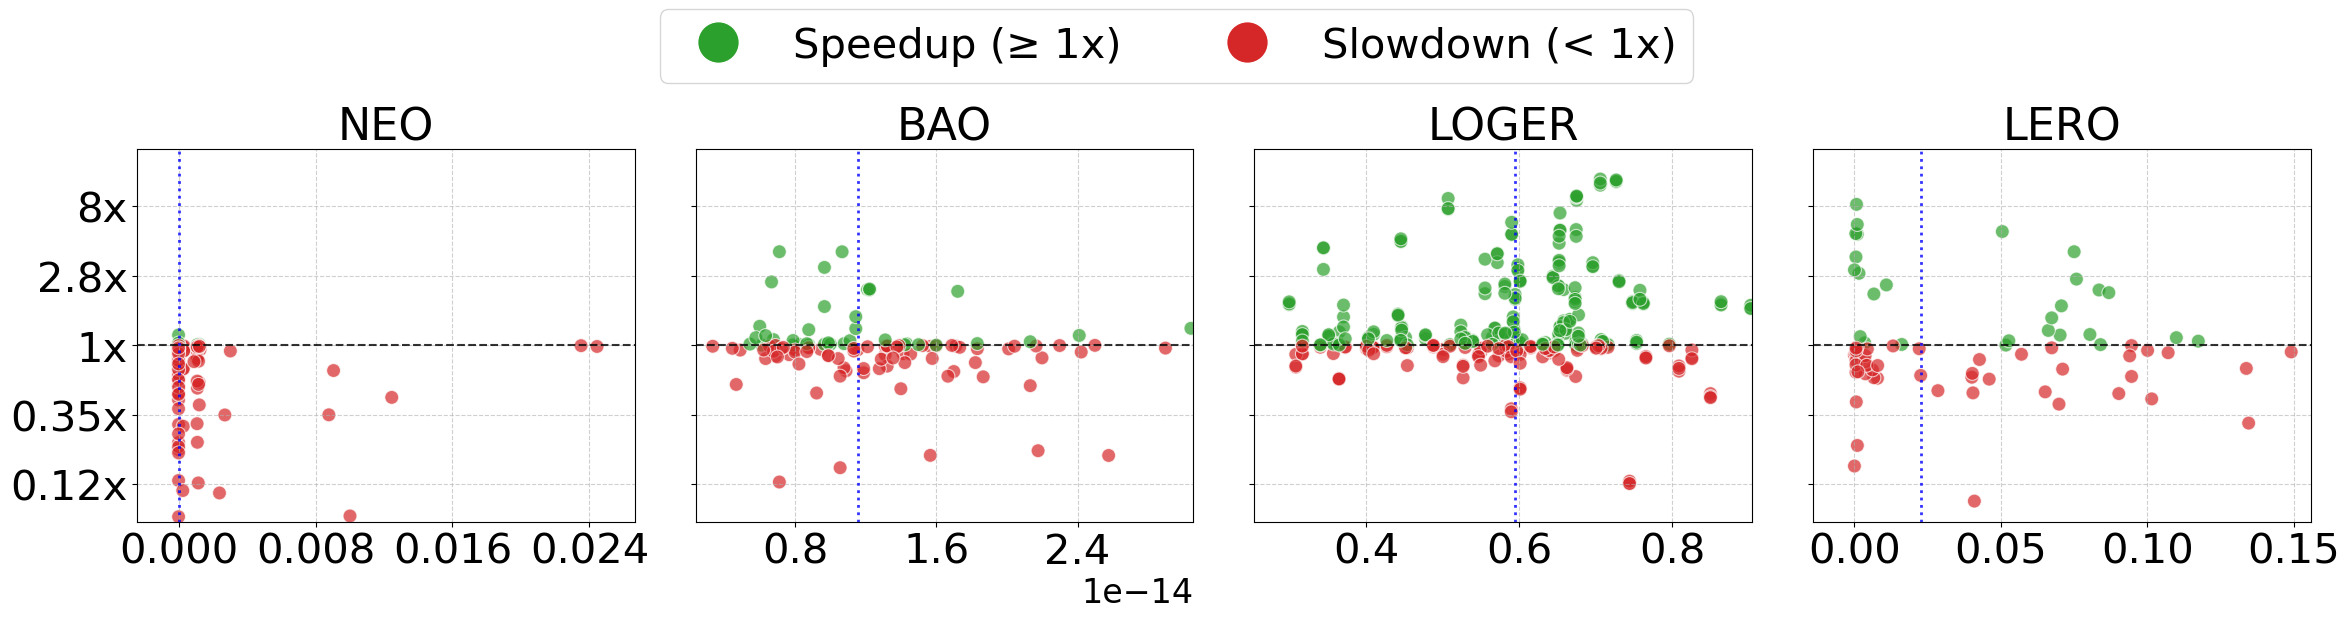

In [29]:
plot_divergence_scatter_row_zoomed(df_all, PLOTS_DIR)

In [30]:
df_tsne = utils.load_and_transform_for_tsne(EXP_ROOT)

# # --- Run the t-SNE Plotting ---
# if 'df_tsne' in locals() and not df_tsne.empty:
#     plots.plot_tsne_analysis(df_tsne, PLOTS_DIR)

Loading NEO embeddings: 100%|██████████| 113/113 [00:00<00:00, 2244.48it/s]


Loading LOGER embeddings: 100%|██████████| 339/339 [00:00<00:00, 2296.53it/s]
/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for BAO...

Running t-SNE for LERO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for LOGER...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for NEO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [31]:
import matplotlib.pyplot as plt
import os

def create_tsne_legend(output_path, lqo_color='#007ACC', postgres_color='#FF4500'):
    """
    Creates a standalone legend for t-SNE analysis per optimizer.

    Args:
        output_path (str): Path to save the legend PDF.
        lqo_color (str): Color for the optimizer (LQO).
        postgres_color (str): Color for PostgreSQL.
    """
    fig_legend = plt.figure(figsize=(6, 2))
    
    from matplotlib.lines import Line2D
    legend_handles = [
        Line2D([0], [0], color=lqo_color, lw=0, marker='o', markersize=12, label='LQO'),
        Line2D([0], [0], color=postgres_color, lw=0, marker='X', markersize=12, label='Postgres')
    ]
    
    fig_legend.legend(handles=legend_handles, loc='center', ncol=2, fontsize=20, handlelength=3.0)
    plt.axis('off')
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    fig_legend.tight_layout()
    fig_legend.savefig(output_path, bbox_inches='tight', dpi=600)
    plt.close(fig_legend)
    
    print(f"t-SNE legend saved to: {output_path}")


# --- Example usage ---
create_tsne_legend("plots/4.4/tsne_legend.pdf")


t-SNE legend saved to: plots/4.4/tsne_legend.pdf


In [32]:
def plot_tsne_analysis_per_optimizer(df, output_dir):
    """
    Creates and saves a separate t-SNE scatter plot for each optimizer,
    with large markers, big fonts, and polished legends.
    """
    if df.empty:
        print("Cannot plot t-SNE: DataFrame is empty.")
        return

    os.makedirs(output_dir, exist_ok=True)
    
    optimizers = df['optimizer'].unique()
    # Set specific order: NEO, BAO, LOGER, LERO
    optimizers = [opt for opt in ['NEO', 'BAO', 'LOGER', 'LERO'] if opt in optimizers]
    
    for opt in optimizers:
        df_opt = df[df['optimizer'] == opt].copy()
        
        if df_opt.empty:
            print(f"No data for optimizer '{opt}', skipping...")
            continue
        
        # Define color/style (PG vs this optimizer)
        palette = {opt: '#007ACC', 'PostgreSQL': '#FF4500'}
        markers = {opt: 'o', 'PostgreSQL': 'X'}

        plt.figure(figsize=(10, 9))
        ax = sns.scatterplot(
            data=df_opt,
            x='tsne_x',
            y='tsne_y',
            hue='plan_type',
            style='plan_type',
            palette=palette,
            markers=markers,
            s=200,             # Bigger markers
            alpha=0.8,
            edgecolor='k',
            linewidth=0.8,
            legend=False
        )
        
        # --- Axes Labels & Tick Sizes ---
        ax.set_xlabel('', fontsize=28)
        ax.set_ylabel('', fontsize=28)
        ax.tick_params(axis='both', labelsize=36)
        
        # --- Legend Styling ---
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles=handles, labels=labels,
        #           title='Plan Origin',
        #           title_fontsize=26,
        #           fontsize=26,
        #           loc='upper center',
        #           bbox_to_anchor=(0.5, 1.24),
        #           frameon=True,
        #           ncol=2)
        
        # --- Grid & layout ---
        ax.grid(True, which='major', linestyle='--', alpha=0.5)
        plt.tight_layout()

        # --- Save Figure ---
        plot_path = os.path.join(output_dir, f"tsne_visualization_{opt}.pdf")
        plt.savefig(plot_path, bbox_inches='tight', dpi=600)
        plt.show()

Loading LOGER embeddings: 100%|██████████| 339/339 [00:00<00:00, 2470.35it/s]
/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for BAO...

Running t-SNE for LERO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for LOGER...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Running t-SNE for NEO...


/data/hdd1/users/kmparmp/miniconda3/envs/jobgen/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


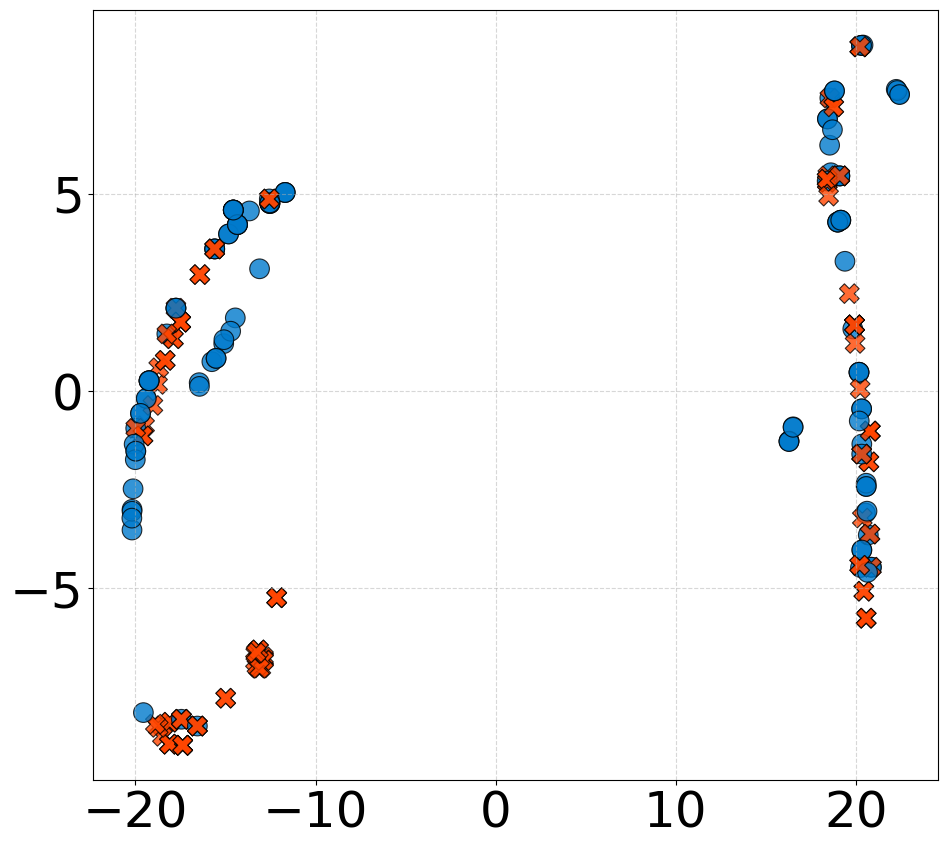

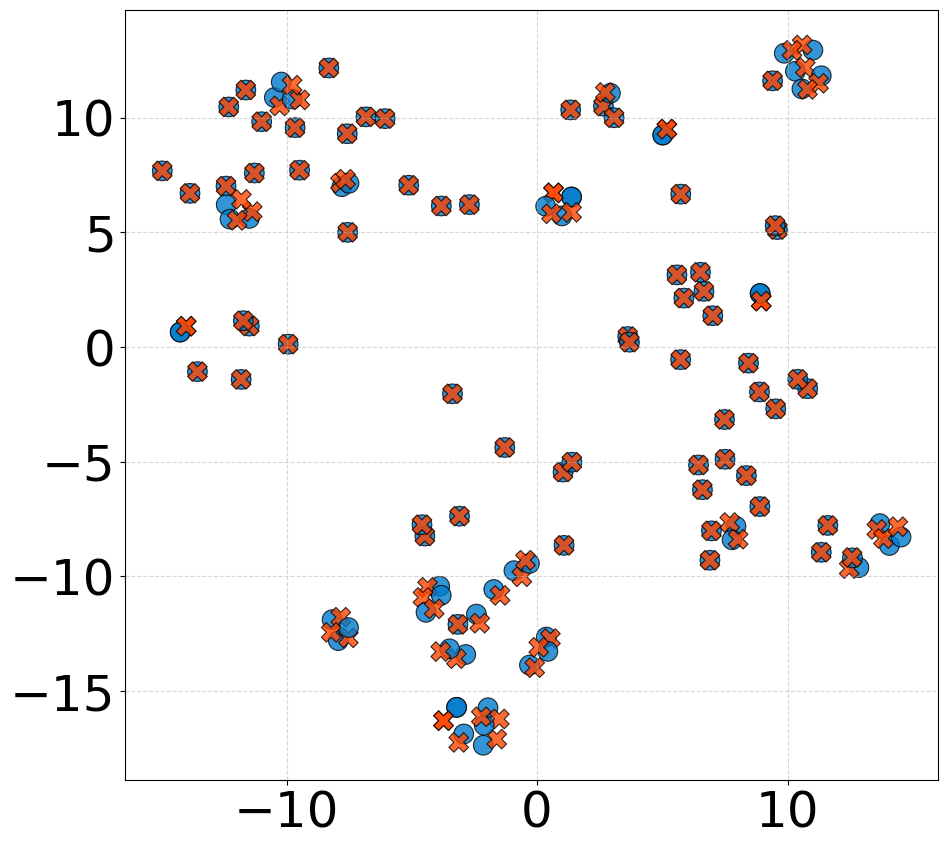

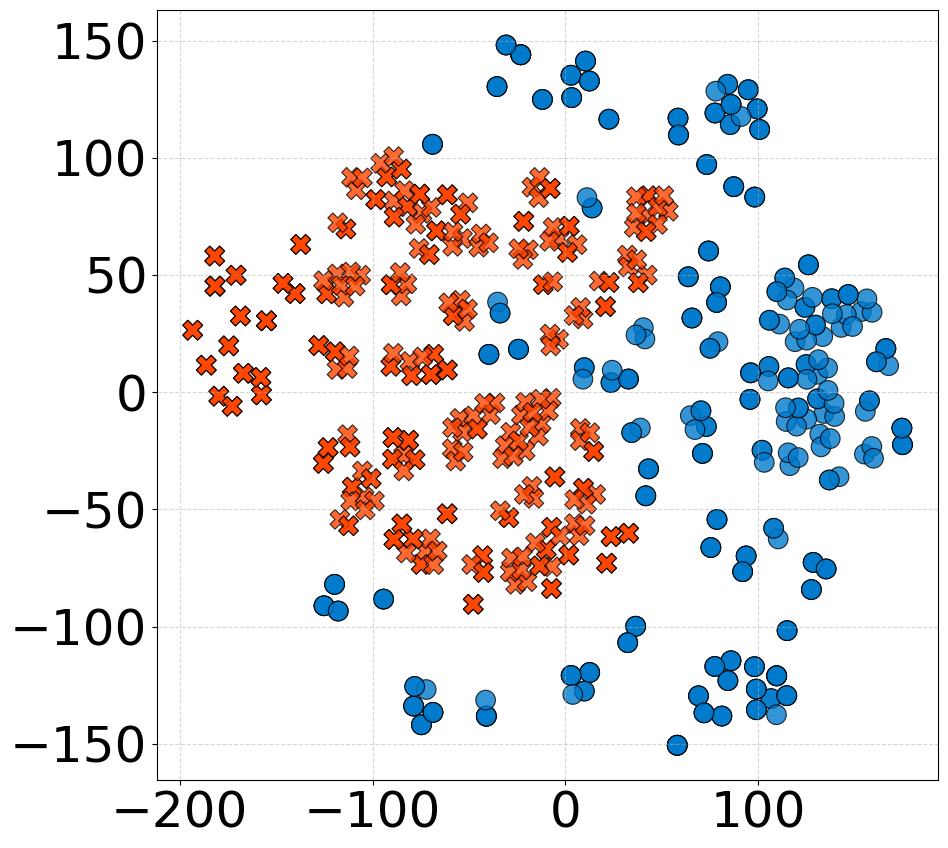

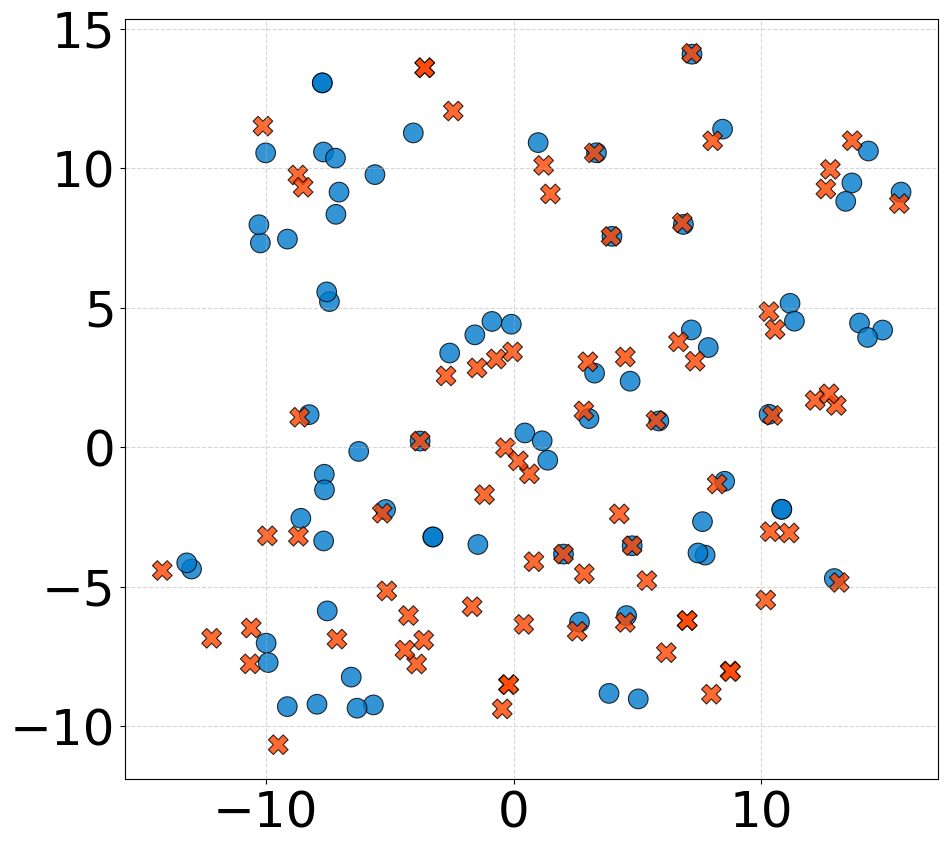

In [33]:
df_tsne = utils.load_and_transform_for_tsne(EXP_ROOT)

# --- Run the t-SNE Plotting ---
if 'df_tsne' in locals() and not df_tsne.empty:
    plot_tsne_analysis_per_optimizer(df_tsne, PLOTS_DIR)

### Experiment 4.5

Evaluate the LQO’s ability to accurately estimate cardinalities and predict query latency:

1. **Cardinality Estimation Accuracy**: 
    - Q-Error Per Node: Compare estimated vs. actual cardinalities for each plan node.
    - Ablation Study: For workloads with poor cardinality estimation, test whether removing cardinality estimates from the encoding improves performance.

2. **Latency Prediction Accuracy**: 
    - Latency Q-Error: Measure the LQO’s ability to predict query execution latency for queries with varying join complexity.
    - Scalability Analysis: Assess whether latency prediction errors increase with higher join counts.

3. **Impact of Increasing Joins**: Track the Q-Error for cardinality estimates and latency predictions as the number of joins increases (e.g., 1 join vs. 5 joins vs. 10 joins).

**Goal**: Understand how well LQOs scale to complex queries and identify areas for improvement in cardinality estimation and latency prediction."			

In [34]:
# NOTE: The data source for this analysis is the 4.2 directory.
EXP_ROOT = os.path.join(BASE_DIR, "4.2")

print(f"Collecting Q-Error data for Experiment 4.4 from: {EXP_ROOT}")
q_errors = utils.collect_latency_q_errors(EXP_ROOT)

print(f"Data collection complete. Found data for join levels: {sorted(q_errors.keys())}")

Data collection complete. Found data for join levels: ['10', '11', '12', '13', '14', '16', '4', '5', '6', '7', '8', '9']



Generating Q-Error plots...
Saving line plot: plots/4.4/q_errors_avg_line_graph.png


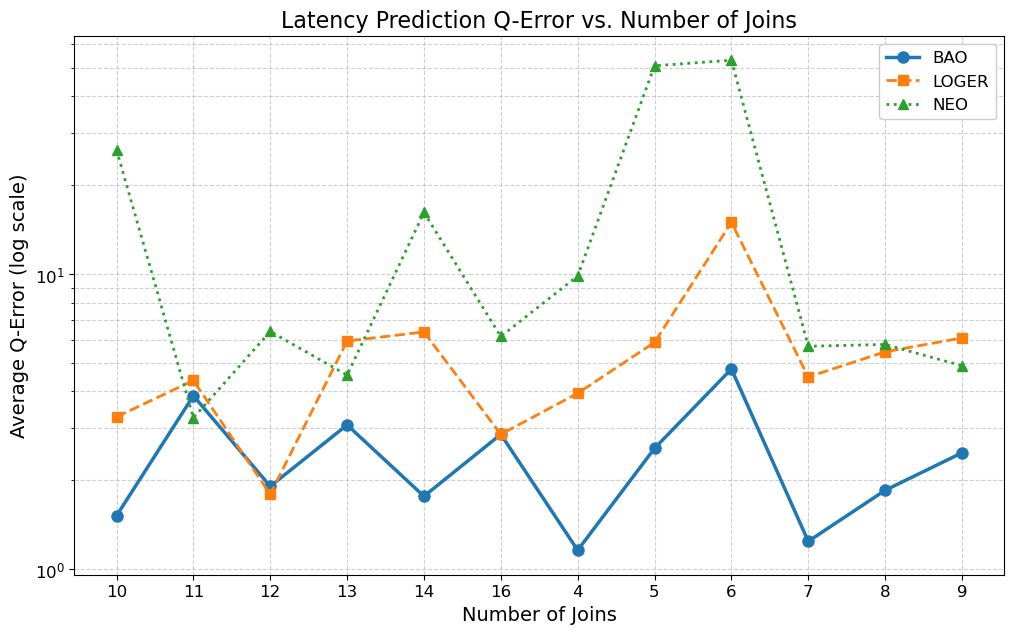

Saving bar plot: plots/4.4/q_errors_bar_graph.png


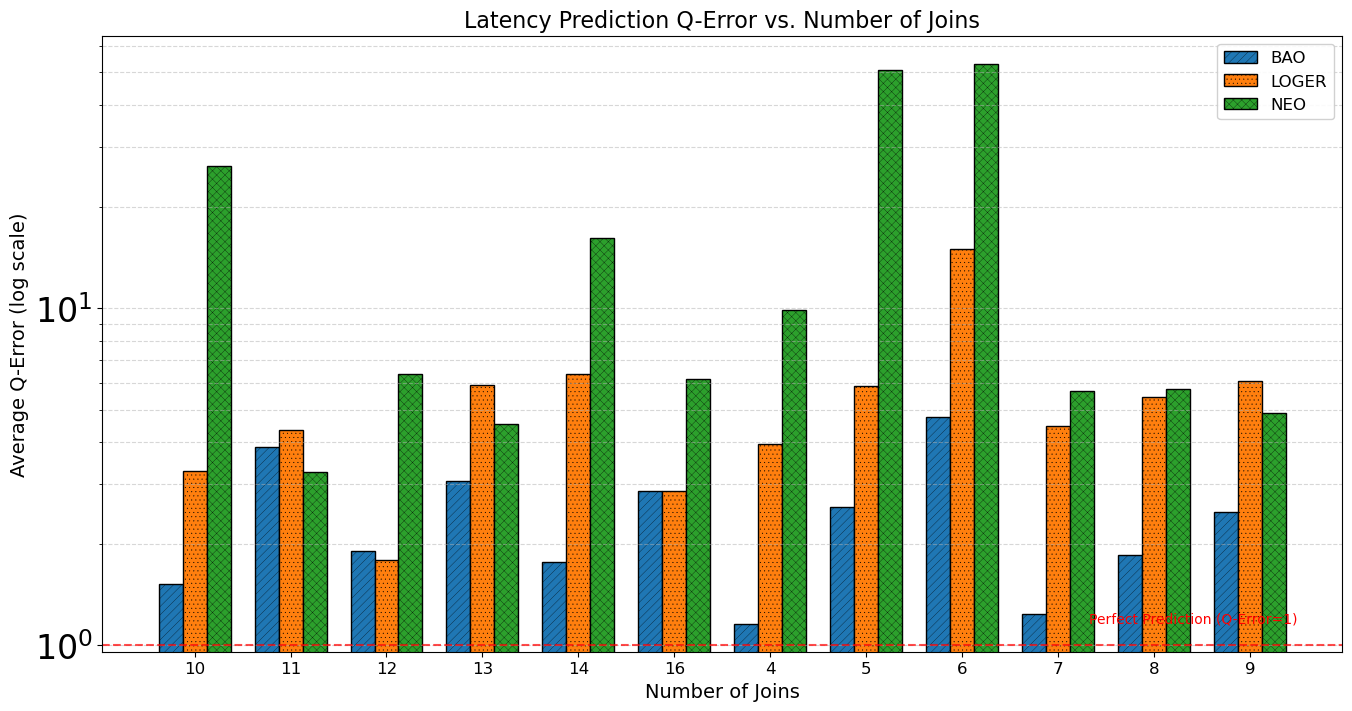


All plots for Experiment 4.4 generated.


In [35]:
print("\nGenerating Q-Error plots...")
plots.plot_q_errors_line(q_errors)
plots.plot_q_errors_bar(q_errors)
print("\nAll plots for Experiment 4.4 generated.")